# Enhancing PV Grid Management Through AC-Power Prediction

- Solar energy generation is rapidly emerging as one of the most promising and fastest-growing renewable sources of power worldwide. With the increasing demand for electrical energy in our daily lives, photovoltaic (PV) cells have become a key player in meeting these needs. PV cells, semiconductor devices, directly convert sunlight energy into electricity through the photovoltaic effect.

- A single solar cell, measuring 4 cm2, produces a voltage of 0.5 to 1 V and can generate 0.7W of power when exposed to sunlight. The most efficiently designed solar panels typically achieve a maximum efficiency of 25%. To enhance voltage and power generation, individual cells are interconnected, with some connected in series and others in parallel.

<p align="center">
  <img src="Assets/Standalone-Solar-Electric-Systems.jpg" alt="Solar Energy Generating System (SEGS)" width="600">
</p>

- PV modules are created by connecting numerous solar cells, and these modules are further linked to form a PV array suitable for applications ranging from small-scale to high-power generation. In a Solar Energy Generating System (SEGS) displayed above, solar panels convert solar energy into Direct Current (DC). This DC is then routed through an inverter to transform it into Alternating Current (AC), making it more compatible with transmission through centralized power grids.

> One of the challenges that needs to be solved is the unpredictability of solar power generation due to weather conditions, panel degradation, and maintenance needs. Grid operators struggle with integrating fluctuating solar energy into the power grid efficiently. There's a critical need for accurate AC-power prediction models that can forecast generation capacity days in advance, allowing for better load balancing and resource allocation. Additionally, the lack of accessible, standardized methods to identify when panels require cleaning or maintenance leads to unnecessary efficiency losses. This project aims to develop predictive models that address these gaps, helping plant operators and grid managers optimize solar energy integration while maximizing power output through timely maintenance interventions.

## Goal

- Analyzing the potential AC-Power generated in next couple of days for better grid management.

- Identify the need for panel cleaning/maintenance through sensor and inverter data.

## Dataset Source

This data has been gathered at two solar power plants in India over a 34 day period. It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. The power generation datasets are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at a plant level - single array of sensors optimally placed at the plant.

Dataset Kaggle Link : https://www.kaggle.com/datasets/anikannal/solar-power-generation-data/data?select=Plant_2_Generation_Data.csv

### Import Libraries and Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = 100
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.float_format', '{:.15f}'.format)

# Requirements
print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.26.4
pandas version :  2.2.1
seaborn version :  0.13.2


#### Load Dataset (Jupyter Notebook)

In [2]:
# Load power generation dataset
plant1_generation = pd.read_csv('Dataset/Plant_1_Generation_Data.csv')
plant2_generation = pd.read_csv('Dataset/Plant_2_Generation_Data.csv')

# Load sensor dataset
plant1_sensor = pd.read_csv('Dataset/Plant_1_Weather_Sensor_Data.csv')
plant2_sensor = pd.read_csv('Dataset/Plant_2_Weather_Sensor_Data.csv')

In [3]:
# Group datesets together
generation_datasets = [plant1_generation, plant2_generation]
sensor_datasets = [plant1_sensor, plant2_sensor]

#### Load Dataset (Google Colab)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# # Load power generation dataset
# plant_1_generation = pd.read_csv('Plant_1_Generation_Data.csv')
# plant_2_generation = pd.read_csv('Plant_2_Generation_Data.csv')

# # Load sensor dataset
# plant_1_sensor = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
# plant_2_sensor = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

# Initial Data Understanding and Pre-Processing

In [6]:
# Checking basic data information
def check_data_information(df, cols):
    """
    This function provides detailed information about each column in a dataframe, including:
    - Data type of the column
    - Number of missing (null) values
    - Percentage of missing values
    - Total number of duplicated rows in the dataframe (not column-specific)
    - Number of unique values in the column
    - A sample of up to 5 unique values from the column

    Parameters:
    df (pd.DataFrame): The dataframe you want to check.
    cols (list): List of column names to check the information from.

    Returns:
    pd.DataFrame: A dataframe with detailed information for each column.
    """
    list_item = []
    for col in cols:
        list_item.append([col,                             # The column name
                          df[col].dtype,                   # The data type of the column
                          df[col].isna().sum(),            # The count of null values in the column
                          round(100 * df[col].isna().sum() / len(df[col]), 2),  # The percentage of null values
                          df.duplicated().sum(),           # The count of duplicated rows in the entire dataframe
                          df[col].nunique(),               # The count of unique values in the column
                          df[col].unique()[:5]])           # A sample of the first 5 unique values in the column

    desc_df = pd.DataFrame(data=list_item, columns='Feature, Data Type, Null Values, Null Percentage, Duplicated Values, Unique Values, Unique Sample'.split(","))
    return desc_df

# Check generation datasets
for i, df in enumerate(generation_datasets, 1):
    columns_to_check = df.columns
    print(f"Generation Data from plant {i}")
    print(f'Number of rows: {df.shape[0]}')
    print(f'Number of columns {df.shape[1]}')
    display(check_data_information(df, columns_to_check))

# Check sensor datasets
for i, df in enumerate(sensor_datasets, 1):
    columns_to_check = df.columns
    print(f"Sensor Data from plant {i}")
    print(f'Number of rows: {df.shape[0]}')
    print(f'Number of columns {df.shape[1]}')
    display(check_data_information(df, columns_to_check))

Generation Data from plant 1
Number of rows: 68778
Number of columns 7


Feature  Data Type   Null Values   Null Percentage   Duplicated Values  \
0    DATE_TIME     object             0               0.0                   0   
1     PLANT_ID      int64             0               0.0                   0   
2   SOURCE_KEY     object             0               0.0                   0   
3     DC_POWER    float64             0               0.0                   0   
4     AC_POWER    float64             0               0.0                   0   
5  DAILY_YIELD    float64             0               0.0                   0   
6  TOTAL_YIELD    float64             0               0.0                   0   

    Unique Values  \
0            3158   
1               1   
2              22   
3           32909   
4           32686   
5           29900   
6           37267   

                                                                                Unique Sample  
0  [15-05-2020 00:00, 15-05-2020 00:15, 15-05-2020 00:30, 15-05-2020 00:45, 15-05-2020 01:00]  
1                                                                                   [4135001]  
2       [1BY6WEcLGh8j5v7, 1IF53ai7Xc0U56Y, 3PZuoBAID5Wc2HD, 7JYdWkrLSPkdwr4, McdE0feGgRqW7Ca]  
3                                                 [0.0, 37.14285714, 53.5, 58.0, 58.42857143]  
4                                        [0.0, 3.585714286, 5.1625, 5.585714286, 5.628571429]  
5                                                         [0.0, 2.625, 3.0, 3.5, 3.142857143]  
6                                     [6259559.0, 6183645.0, 6987759.0, 7602960.0, 7158964.0]

Generation Data from plant 2
Number of rows: 67698
Number of columns 7


Feature  Data Type   Null Values   Null Percentage   Duplicated Values  \
0    DATE_TIME     object             0               0.0                   0   
1     PLANT_ID      int64             0               0.0                   0   
2   SOURCE_KEY     object             0               0.0                   0   
3     DC_POWER    float64             0               0.0                   0   
4     AC_POWER    float64             0               0.0                   0   
5  DAILY_YIELD    float64             0               0.0                   0   
6  TOTAL_YIELD    float64             0               0.0                   0   

    Unique Values  \
0            3259   
1               1   
2              22   
3           30825   
4           30783   
5           30490   
6           33115   

                                                                                               Unique Sample  
0  [2020-05-15 00:00:00, 2020-05-15 00:15:00, 2020-05-15 00:30:00, 2020-05-15 00:45:00, 2020-05-15 01:00:00]  
1                                                                                                  [4136001]  
2                      [4UPUqMRk7TRMgml, 81aHJ1q11NBPMrL, 9kRcWv60rDACzjR, Et9kgGMDl729KT4, IQ2d7wF4YD8zU1Q]  
3                                   [0.0, 15.406666666666665, 14.773333333333332, 15.38, 14.973333333333334]  
4                                                             [0.0, 14.86, 14.246666666666668, 14.84, 14.44]  
5                                               [9425.0, 0.0, 3075.3333333333344, 269.9333333333333, 3177.0]  
6                                             [2429011.0, 1215278736.0, 2247719577.0, 1704250.0, 19941526.0]

Sensor Data from plant 1
Number of rows: 3182
Number of columns 6


Feature  Data Type   Null Values   Null Percentage  \
0            DATE_TIME     object             0               0.0   
1             PLANT_ID      int64             0               0.0   
2           SOURCE_KEY     object             0               0.0   
3  AMBIENT_TEMPERATURE    float64             0               0.0   
4   MODULE_TEMPERATURE    float64             0               0.0   
5          IRRADIATION    float64             0               0.0   

    Duplicated Values   Unique Values  \
0                   0            3182   
1                   0               1   
2                   0               1   
3                   0            3182   
4                   0            3182   
5                   0            1758   

                                                                                               Unique Sample  
0  [2020-05-15 00:00:00, 2020-05-15 00:15:00, 2020-05-15 00:30:00, 2020-05-15 00:45:00, 2020-05-15 01:00:00]  
1                                                                                                  [4135001]  
2                                                                                          [HmiyD2TTLFNqkNe]  
3                [25.184316133333333, 25.08458866666667, 24.935752600000004, 24.8461304, 24.621525357142858]  
4                 [22.8575074, 22.761667866666663, 22.59230553333333, 22.36085213333333, 22.165422642857145]  
5                      [0.0, 0.0008627212413333, 0.0058869571866666, 0.0222816074666666, 0.0494097238666666]

Sensor Data from plant 2
Number of rows: 3259
Number of columns 6


Feature  Data Type   Null Values   Null Percentage  \
0            DATE_TIME     object             0               0.0   
1             PLANT_ID      int64             0               0.0   
2           SOURCE_KEY     object             0               0.0   
3  AMBIENT_TEMPERATURE    float64             0               0.0   
4   MODULE_TEMPERATURE    float64             0               0.0   
5          IRRADIATION    float64             0               0.0   

    Duplicated Values   Unique Values  \
0                   0            3259   
1                   0               1   
2                   0               1   
3                   0            3259   
4                   0            3259   
5                   0            1863   

                                                                                               Unique Sample  
0  [2020-05-15 00:00:00, 2020-05-15 00:15:00, 2020-05-15 00:30:00, 2020-05-15 00:45:00, 2020-05-15 01:00:00]  
1                                                                                                  [4136001]  
2                                                                                          [iq8k7ZNt4Mwm3w0]  
3                [27.004763700000005, 26.880811433333328, 26.682055344827592, 26.500588900000004, 26.596148]  
4                       [25.0607889, 24.421868833333328, 24.427290310344823, 24.4206776, 25.088210413793107]  
5                                 [0.0, 0.002838054505, 0.0129619781466666, 0.0210376687241379, 0.042435399]

## Files and Features Description

**A. Generation data : Solar power generation data for one plant gathered at 15 minutes intervals over a 34 days period.**

- **DATE_TIME**
  - Definition: Date and time for each observation. Observations recorded at 15 minute intervals.

- **PLANT_ID**
  - Definition: Number ID of the plant (this will be common for the entire file)

- **SOURCE_KEY**
  - Definition: Number ID of the inverter

- **DC_POWER**
  - Definition: Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.

- **AC_POWER**
  - Definition: Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.

- **DAILY_YIELD**
  - Definition: Daily yield is a cumulative sum of power generated on that day, till that point in time.

- **TOTAL_YIELD**
  - Definition: This is the total yield for the inverter till that point in time.

**B. Weather Sensor Data : Weather sensor data gathered for one solar plant every 15 minutes over a 34 days period.**

- **DATE_TIME**
  - Definition: Date and time for each observation. Observations recorded at 15 minute intervals.

- **PLANT_ID**
  - Definition: Number ID of the plant (this will be common for the entire file)

- **SOURCE_KEY**
  - Definition: Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant.

- **AMBIENT_TEMPERATURE**
  - Definition: This is the ambient temperature at the plant.

- **MODULE_TEMPERATURE**
  - Definition: There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module.

- **IRRADIATION**
  - Definition: Amount of irradiation for the 15 minute interval.

! Important notes regarding irradiance understanding : 

- Solar irradiance is the power per unit area (surface power density) received from the Sun in the form of electromagnetic radiation in the wavelength range of the measuring instrument. Solar irradiance is measured in watts per square metre (W/m2) in SI units.

- Solar irradiance is often integrated over a given time period in order to report the radiant energy emitted into the surrounding environment (joule per square metre, J/m2) during that time period. This integrated solar irradiance is called solar irradiation, solar exposure, solar insolation, or insolation.

- Irradiance may be measured in space or at the Earth's surface after atmospheric absorption and scattering. Irradiance in space is a function of distance from the Sun, the solar cycle, and cross-cycle changes. Irradiance on the Earth's surface additionally depends on the tilt of the measuring surface, the height of the Sun above the horizon, and atmospheric conditions.

- Since the strength of solar radiation reaching Earth is not evenly distributed across the electromagnetic spectrum, in addition to the total solar irradiance (TSI), measurement of the spectral solar irradiance (SSI) is also essential, especially as it interacts with different materials and processes on the Earth’s surface and atmosphere in different ways. SSI will allow scientists to adequately understand and resolve the relationships between the different wavelengths of sunlight and the properties of the materials they interact with, and can serve as the basis for the retrieval of geophysical quantities of various materials and phenomena by remote sensing, as well as the calibration of many of the instruments used for such measurements. SSI measured at the top of the atmosphere (TOA) and integrated across 200–2400 nm represents 97% of the TSI.

<p align="center">
  <img src="Assets/TSIS diagram_annotated.jpg" alt="Simulated spectral solar irradiance" width="600">
</p>

- Picture above is the Simulated spectral solar irradiance at the top of the atmosphere (ToA) and the Earth's surface. The different regions of the spectrum include: ultraviolet (UV), visible, near infrared (NIR), and shortwave infrared (SWIR). The range typically covered by SSI is indicated by the broken line at the top. The regions of spectrum where irradiance is absorbed by various atmospheric constituents are indicated, including: ozone (O3), oxygen (O2), water vapor (H2O), carbon dioxide (CO2), and methane (CH4). Graphics by Luke Ellison.

In [7]:
plant1_generation.head(25)

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0   15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1   15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2   15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3   15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4   15-05-2020 00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   
5   15-05-2020 00:00   4135001  VHMLBKoKgIrUVDU       0.0       0.0   
6   15-05-2020 00:00   4135001  WRmjgnKYAwPKWDb       0.0       0.0   
7   15-05-2020 00:00   4135001  ZnxXDlPa8U1GXgE       0.0       0.0   
8   15-05-2020 00:00   4135001  ZoEaEvLYb1n2sOq       0.0       0.0   
9   15-05-2020 00:00   4135001  adLQvlD726eNBSB       0.0       0.0   
10  15-05-2020 00:00   4135001  bvBOhCH3iADSZry       0.0       0.0   
11  15-05-2020 00:00   4135001  iCRJl6heRkivqQ3       0.0       0.0   
12  15-05-2020 00:00   4135001  ih0vzX44oOqAx2f       0.0       0.0   
13  15-05-2020 00:00   4135001  pkci93gMrogZuBj       0.0       0.0   
14  15-05-2020 00:00   4135001  rGa61gmuvPhdLxV       0.0       0.0   
15  15-05-2020 00:00   4135001  sjndEbLyjtCKgGv       0.0       0.0   
16  15-05-2020 00:00   4135001  uHbuxQJl8lW7ozc       0.0       0.0   
17  15-05-2020 00:00   4135001  wCURE6d3bPkepu2       0.0       0.0   
18  15-05-2020 00:00   4135001  z9Y9gH1T5YWrNuG       0.0       0.0   
19  15-05-2020 00:00   4135001  zBIq5rxdHJRwDNY       0.0       0.0   
20  15-05-2020 00:00   4135001  zVJPv84UY57bAof       0.0       0.0   
21  15-05-2020 00:15   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
22  15-05-2020 00:15   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
23  15-05-2020 00:15   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
24  15-05-2020 00:15   4135001  7JYdWkrLSPkdwr4       0.0       0.0   

    DAILY_YIELD  TOTAL_YIELD  
0           0.0    6259559.0  
1           0.0    6183645.0  
2           0.0    6987759.0  
3           0.0    7602960.0  
4           0.0    7158964.0  
5           0.0    7206408.0  
6           0.0    7028673.0  
7           0.0    6522172.0  
8           0.0    7098099.0  
9           0.0    6271355.0  
10          0.0    6316803.0  
11          0.0    7177992.0  
12          0.0    6185184.0  
13          0.0    7169102.0  
14          0.0    7111493.0  
15          0.0    7016832.0  
16          0.0    7038681.0  
17          0.0    6782598.0  
18          0.0    7007866.0  
19          0.0    6339380.0  
20          0.0    7116151.0  
21          0.0    6259559.0  
22          0.0    6183645.0  
23          0.0    6987759.0  
24          0.0    7602960.0

In [8]:
plant2_generation.head(25)

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0   2020-05-15 00:00:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
1   2020-05-15 00:00:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
2   2020-05-15 00:00:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
3   2020-05-15 00:00:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
4   2020-05-15 00:00:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   
5   2020-05-15 00:00:00   4136001  LYwnQax7tkwH5Cb       0.0       0.0   
6   2020-05-15 00:00:00   4136001  LlT2YUhhzqhg5Sw       0.0       0.0   
7   2020-05-15 00:00:00   4136001  Mx2yZCDsyf6DPfv       0.0       0.0   
8   2020-05-15 00:00:00   4136001  NgDl19wMapZy17u       0.0       0.0   
9   2020-05-15 00:00:00   4136001  PeE6FRyGXUgsRhN       0.0       0.0   
10  2020-05-15 00:00:00   4136001  Qf4GUc1pJu5T6c6       0.0       0.0   
11  2020-05-15 00:00:00   4136001  Quc1TzYxW2pYoWX       0.0       0.0   
12  2020-05-15 00:00:00   4136001  V94E5Ben1TlhnDV       0.0       0.0   
13  2020-05-15 00:00:00   4136001  WcxssY2VbP4hApt       0.0       0.0   
14  2020-05-15 00:00:00   4136001  mqwcsP2rE7J0TFp       0.0       0.0   
15  2020-05-15 00:00:00   4136001  oZ35aAeoifZaQzV       0.0       0.0   
16  2020-05-15 00:00:00   4136001  oZZkBaNadn6DNKz       0.0       0.0   
17  2020-05-15 00:00:00   4136001  q49J1IKaHRwDQnt       0.0       0.0   
18  2020-05-15 00:00:00   4136001  rrq4fwE8jgrTyWY       0.0       0.0   
19  2020-05-15 00:00:00   4136001  vOuJvMaM2sgwLmb       0.0       0.0   
20  2020-05-15 00:00:00   4136001  xMbIugepa2P7lBB       0.0       0.0   
21  2020-05-15 00:00:00   4136001  xoJJ8DcxJEcupym       0.0       0.0   
22  2020-05-15 00:15:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
23  2020-05-15 00:15:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
24  2020-05-15 00:15:00   4136001  9kRcWv60rDACzjR       0.0       0.0   

    DAILY_YIELD   TOTAL_YIELD  
0   9425.000000  2.429011e+06  
1      0.000000  1.215279e+09  
2   3075.333333  2.247720e+09  
3    269.933333  1.704250e+06  
4   3177.000000  1.994153e+07  
5   1872.500000  1.794959e+09  
6   1094.357143  2.825928e+08  
7   5692.200000  2.453646e+06  
8   1866.200000  1.115126e+08  
9    651.200000  1.348351e+09  
10     0.000000  8.384214e+08  
11  5495.000000  3.295091e+08  
12     0.000000  1.412083e+09  
13     0.000000  1.816953e+08  
14  1238.533333  5.935800e+08  
15  1281.466667  1.659965e+09  
16     0.000000  1.708083e+09  
17  4315.000000  3.399230e+05  
18   280.214286  1.209641e+08  
19     0.000000  2.211962e+06  
20  9166.000000  1.066566e+08  
21     0.000000  2.091436e+08  
22  9425.000000  2.429011e+06  
23     0.000000  1.215279e+09  
24     0.000000  2.247720e+09

In [9]:
plant1_sensor.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0  2020-05-15 00:00:00   4135001  HmiyD2TTLFNqkNe            25.184316   
1  2020-05-15 00:15:00   4135001  HmiyD2TTLFNqkNe            25.084589   
2  2020-05-15 00:30:00   4135001  HmiyD2TTLFNqkNe            24.935753   
3  2020-05-15 00:45:00   4135001  HmiyD2TTLFNqkNe            24.846130   
4  2020-05-15 01:00:00   4135001  HmiyD2TTLFNqkNe            24.621525   

   MODULE_TEMPERATURE  IRRADIATION  
0           22.857507          0.0  
1           22.761668          0.0  
2           22.592306          0.0  
3           22.360852          0.0  
4           22.165423          0.0

In [10]:
plant2_sensor.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0  2020-05-15 00:00:00   4136001  iq8k7ZNt4Mwm3w0            27.004764   
1  2020-05-15 00:15:00   4136001  iq8k7ZNt4Mwm3w0            26.880811   
2  2020-05-15 00:30:00   4136001  iq8k7ZNt4Mwm3w0            26.682055   
3  2020-05-15 00:45:00   4136001  iq8k7ZNt4Mwm3w0            26.500589   
4  2020-05-15 01:00:00   4136001  iq8k7ZNt4Mwm3w0            26.596148   

   MODULE_TEMPERATURE  IRRADIATION  
0           25.060789          0.0  
1           24.421869          0.0  
2           24.427290          0.0  
3           24.420678          0.0  
4           25.088210          0.0

Just from these information, there are some useful insight to this data that understanding it could make it easier for further analysis and feature transformation, they are :

- Date feature have the wrong format should be in datetime instead of object.
- In generation data, the recorded data is not aggregated on 15 minute interval but still on individual data recording, will have to change that later. This is not the case for sensor data.
- Although group by not actually needed for sensor data, it's good to also do group by on sensor data to remove PLANT_ID and SOURCE_KEY (we could also do this just by casually dropping the columns) since we wont be needing those for analysis especially later on making model

In [11]:
# Aggregate plant 1 generation data by datetime
plant1_generation_agg = plant1_generation.groupby('DATE_TIME')[['DC_POWER','AC_POWER']].agg('sum').reset_index()
plant1_generation_agg

DATE_TIME  DC_POWER  AC_POWER
0     01-06-2020 00:00       0.0       0.0
1     01-06-2020 00:15       0.0       0.0
2     01-06-2020 00:30       0.0       0.0
3     01-06-2020 00:45       0.0       0.0
4     01-06-2020 01:00       0.0       0.0
...                ...       ...       ...
3153  31-05-2020 22:45       0.0       0.0
3154  31-05-2020 23:00       0.0       0.0
3155  31-05-2020 23:15       0.0       0.0
3156  31-05-2020 23:30       0.0       0.0
3157  31-05-2020 23:45       0.0       0.0

[3158 rows x 3 columns]

In [12]:
# Aggregate plant 2 generation data by datetime
plant2_generation_agg = plant2_generation.groupby('DATE_TIME')[['DC_POWER','AC_POWER']].agg('sum').reset_index()
plant2_generation_agg

DATE_TIME  DC_POWER  AC_POWER
0     2020-05-15 00:00:00       0.0       0.0
1     2020-05-15 00:15:00       0.0       0.0
2     2020-05-15 00:30:00       0.0       0.0
3     2020-05-15 00:45:00       0.0       0.0
4     2020-05-15 01:00:00       0.0       0.0
...                   ...       ...       ...
3254  2020-06-17 22:45:00       0.0       0.0
3255  2020-06-17 23:00:00       0.0       0.0
3256  2020-06-17 23:15:00       0.0       0.0
3257  2020-06-17 23:30:00       0.0       0.0
3258  2020-06-17 23:45:00       0.0       0.0

[3259 rows x 3 columns]

**Update (15/03/2025):**
1. In this case we wont be using the aggregation for the daily and total yield since by definition they actually not make sense to sum by datetime.

2. If we want to do analysis on the DAILY_YIELD and TOTAL_YIELD, then we would have to take the sum of the latest TOTAL_YIELD per inverter with something like this

    `latest_total_yield = plant1_generation.groupby('SOURCE_KEY')['TOTAL_YIELD'].last().sum()`

    Further information please refer to this: https://chat.deepseek.com/a/chat/s/0ab6ca91-14a6-4f53-b578-126922db43da

In [13]:
#Aggregate plant 1 sensor data by datetime
plant1_sensor_agg = plant1_sensor.groupby('DATE_TIME')[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE', 'IRRADIATION']].agg('sum').reset_index()
plant1_sensor_agg

DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
0     2020-05-15 00:00:00            25.184316           22.857507   
1     2020-05-15 00:15:00            25.084589           22.761668   
2     2020-05-15 00:30:00            24.935753           22.592306   
3     2020-05-15 00:45:00            24.846130           22.360852   
4     2020-05-15 01:00:00            24.621525           22.165423   
...                   ...                  ...                 ...   
3177  2020-06-17 22:45:00            22.150570           21.480377   
3178  2020-06-17 23:00:00            22.129816           21.389024   
3179  2020-06-17 23:15:00            22.008275           20.709211   
3180  2020-06-17 23:30:00            21.969495           20.734963   
3181  2020-06-17 23:45:00            21.909288           20.427972   

      IRRADIATION  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
3177          0.0  
3178          0.0  
3179          0.0  
3180          0.0  
3181          0.0  

[3182 rows x 4 columns]

In [14]:
#Aggregate plant 2 sensor data by datetime
plant2_sensor_agg = plant2_sensor.groupby('DATE_TIME')[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE', 'IRRADIATION']].agg('sum').reset_index()
plant2_sensor_agg

DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
0     2020-05-15 00:00:00            27.004764           25.060789   
1     2020-05-15 00:15:00            26.880811           24.421869   
2     2020-05-15 00:30:00            26.682055           24.427290   
3     2020-05-15 00:45:00            26.500589           24.420678   
4     2020-05-15 01:00:00            26.596148           25.088210   
...                   ...                  ...                 ...   
3254  2020-06-17 22:45:00            23.511703           22.856201   
3255  2020-06-17 23:00:00            23.482282           22.744190   
3256  2020-06-17 23:15:00            23.354743           22.492245   
3257  2020-06-17 23:30:00            23.291048           22.373909   
3258  2020-06-17 23:45:00            23.202871           22.535908   

      IRRADIATION  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
3254          0.0  
3255          0.0  
3256          0.0  
3257          0.0  
3258          0.0  

[3259 rows x 4 columns]

In [15]:
# Convert DATE_TIME feature into datetime format

# Plant 1 generation data
plant1_generation_agg['DATE_TIME'] = pd.to_datetime(plant1_generation_agg['DATE_TIME'], format="%d-%m-%Y %H:%M")
plant1_generation_agg['TIME'] = plant1_generation_agg['DATE_TIME'].dt.time
plant1_generation_agg['DATE'] = plant1_generation_agg['DATE_TIME'].dt.date

# Plant 2 generation data
plant2_generation_agg['DATE_TIME'] = pd.to_datetime(plant2_generation_agg['DATE_TIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
plant2_generation_agg['TIME'] = plant2_generation_agg['DATE_TIME'].dt.time
plant2_generation_agg['DATE'] = plant2_generation_agg['DATE_TIME'].dt.date

# Plant 1 sensor data
plant1_sensor_agg['DATE_TIME'] = pd.to_datetime(plant1_sensor_agg['DATE_TIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
plant1_sensor_agg['TIME'] = plant1_sensor_agg['DATE_TIME'].dt.time 
plant1_sensor_agg['DATE'] = plant1_sensor_agg['DATE_TIME'].dt.date

# Plant 2 sensor data
plant2_sensor_agg['DATE_TIME'] = pd.to_datetime(plant2_sensor_agg['DATE_TIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
plant2_sensor_agg['TIME'] = plant2_sensor_agg['DATE_TIME'].dt.time 
plant2_sensor_agg['DATE'] = plant2_sensor_agg['DATE_TIME'].dt.date

In [16]:
# # Initial data transformation :  converting column name to lowercase
# for dataset in datasets :
#     dataset.columns = dataset.columns.str.lower()

# Further EDA on Generation Data (Univariate and Bivariate)

In [17]:
# Describe columns on plant 1
plant1_generation_agg.describe().transpose()

count                           mean                  min  \
DATE_TIME    3158  2020-06-01 06:42:44.344521728  2020-05-15 00:00:00   
DC_POWER   3158.0                   68547.713729                  0.0   
AC_POWER   3158.0                    6703.628149                  0.0   

                           25%                  50%                  75%  \
DATE_TIME  2020-05-23 23:18:45  2020-06-01 12:37:30  2020-06-09 17:56:15   
DC_POWER                   0.0          8515.285714        140386.504463   
AC_POWER                   0.0           823.033036         13750.606696   

                           max           std  
DATE_TIME  2020-06-17 23:45:00           NaN  
DC_POWER          298937.78571  88044.612181  
AC_POWER          29150.212499   8603.120476

In [18]:
# Describe columns on plant 2
plant2_generation_agg.describe().transpose()

count                           mean                  min  \
DATE_TIME    3259  2020-06-01 00:04:35.053697536  2020-05-15 00:00:00   
DC_POWER   3259.0                    5124.648465                  0.0   
AC_POWER   3259.0                    5011.974903                  0.0   

                           25%                  50%                  75%  \
DATE_TIME  2020-05-23 12:07:30  2020-06-01 00:00:00  2020-06-09 12:07:30   
DC_POWER                   0.0           494.427143         11048.773333   
AC_POWER                   0.0           477.536667         10795.727619   

                           max          std  
DATE_TIME  2020-06-17 23:45:00          NaN  
DC_POWER          26630.506667  6462.118509  
AC_POWER          25979.760476  6317.872611

Number of inverter in Plant 1 : 22


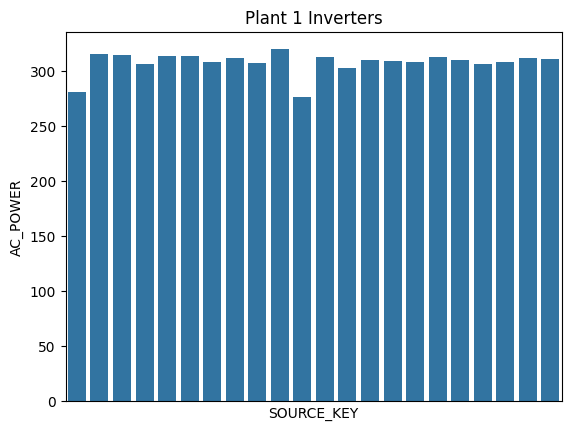

Number of inverter in Plant 2 : 22


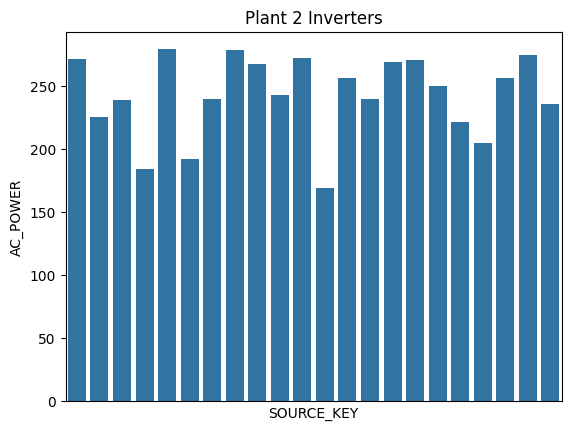

In [19]:
# Check for faulty in inverters/modules
print(f'Number of inverter in Plant 1 : {plant1_generation['SOURCE_KEY'].nunique()}')
sns.barplot(x='SOURCE_KEY', y='AC_POWER', data=plant1_generation, ci=None)
plt.title('Plant 1 Inverters')
plt.xticks([])
plt.show()

print(f'Number of inverter in Plant 2 : {plant2_generation['SOURCE_KEY'].nunique()}')
sns.barplot(x='SOURCE_KEY', y='AC_POWER', data=plant2_generation, ci=None)
plt.title('Plant 2 Inverters')
plt.xticks([])
plt.show()

> The inverters in Plant 1 exhibit consistent outputs, whereas those in Plant 2 show fluctuations. This variance in Plant 2's output could potentially be attributed to malfunctioning inverters, assuming the solar modules are in good working condition.

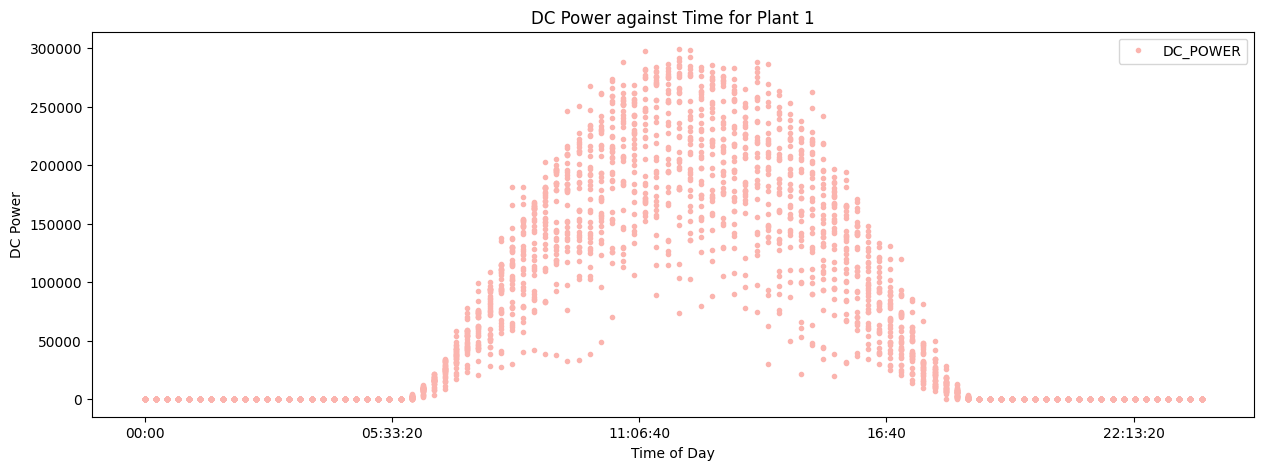

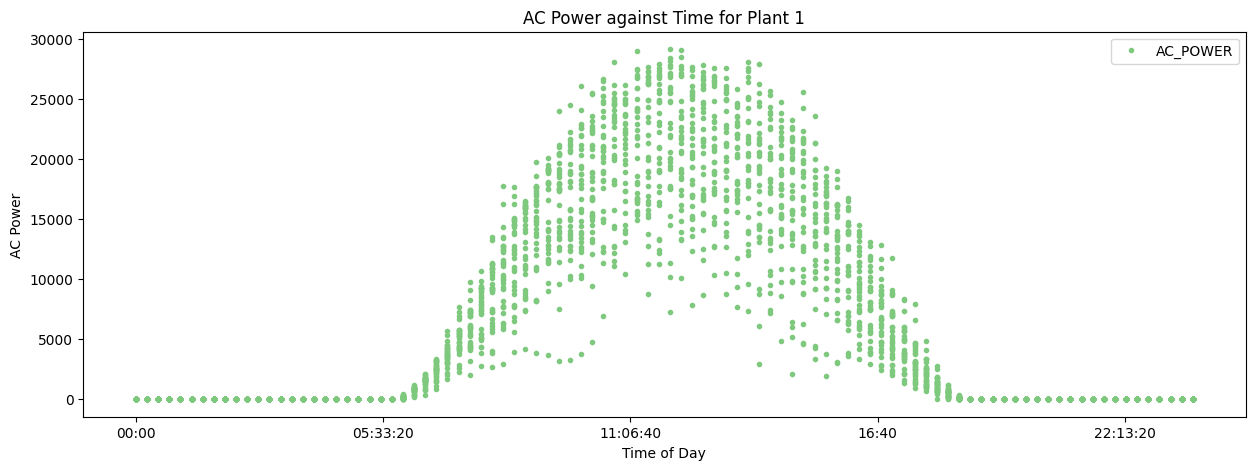

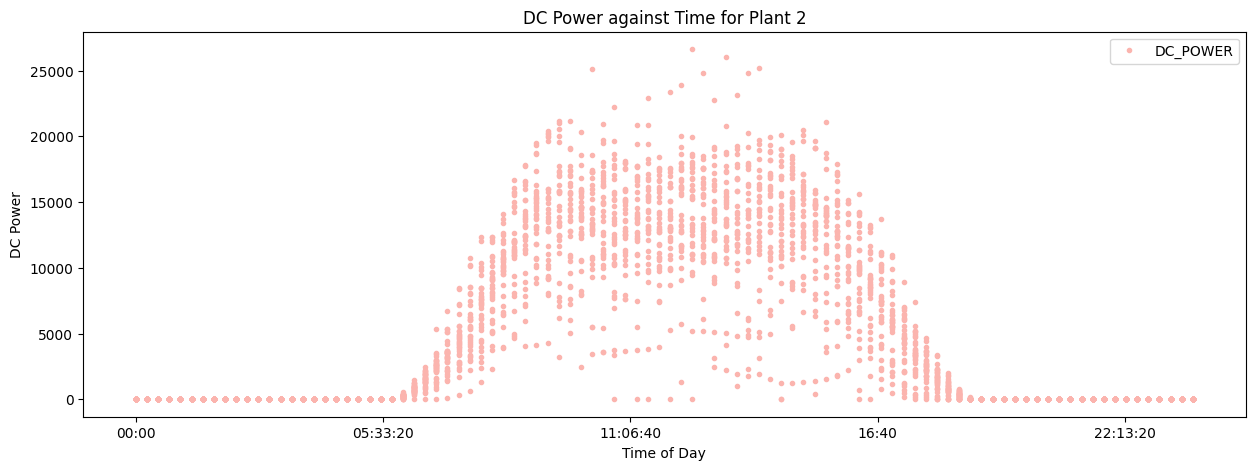

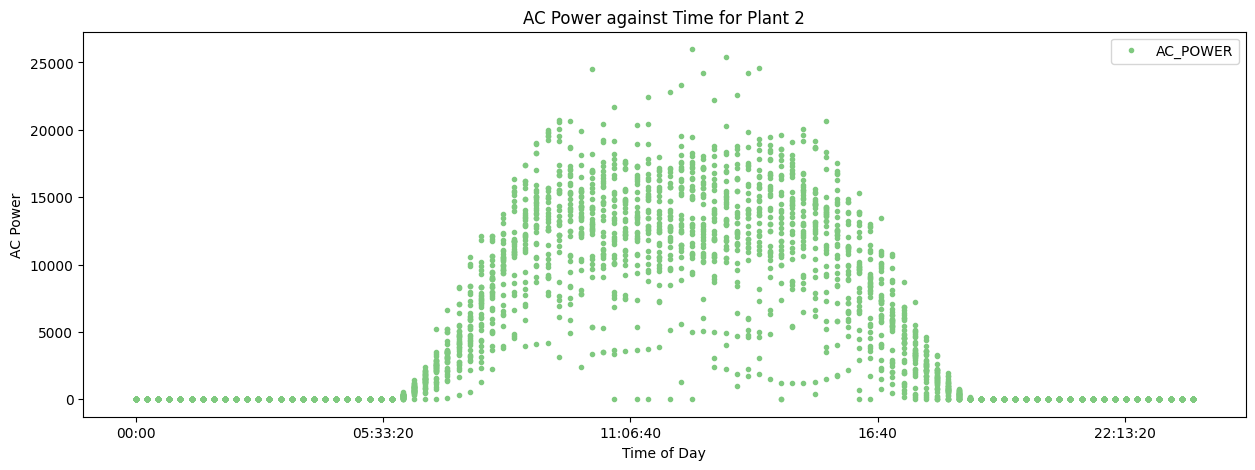

In [20]:
# Check power generation againts time in a day
plant1_generation_agg.plot(x='TIME', y='DC_POWER', style='.', figsize = (15, 5), colormap='Pastel1')
plt.ylabel('DC Power')
plt.xlabel('Time of Day')
plt.title('DC Power against Time for Plant 1')
plt.show()

plant1_generation_agg.plot(x='TIME', y='AC_POWER', style='.', figsize = (15, 5), colormap='Accent') 
plt.ylabel('AC Power')
plt.xlabel('Time of Day')
plt.title('AC Power against Time for Plant 1')
plt.show()

plant2_generation_agg.plot(x='TIME', y='DC_POWER', style='.', figsize = (15, 5), colormap='Pastel1')
plt.ylabel('DC Power')
plt.xlabel('Time of Day')
plt.title('DC Power against Time for Plant 2')
plt.show()

plant2_generation_agg.plot(x='TIME', y='AC_POWER', style='.', figsize = (15, 5), colormap='Accent') 
plt.ylabel('AC Power')
plt.xlabel('Time of Day')
plt.title('AC Power against Time for Plant 2')
plt.show()

- The generation of power relies on sunlight, commencing around 5:40 in the morning and concluding approximately at 6:00 in the evening. The availability of sunlight is determined by its intensity and wavelength upon reaching the PV cells. Despite sunlight still being present at 6:00 PM, it consists of diffused and scattered sunlight lacking the requisite wavelength for power generation.

- Plant 2 demonstrates increased variations in AC and DC power values, indicating that the issue may not lie with faulty inverters but rather with the modules themselves.

- We can also see that overall, the power generated from Plant 1 have higher values compared to Plant 2, we will check that down below.

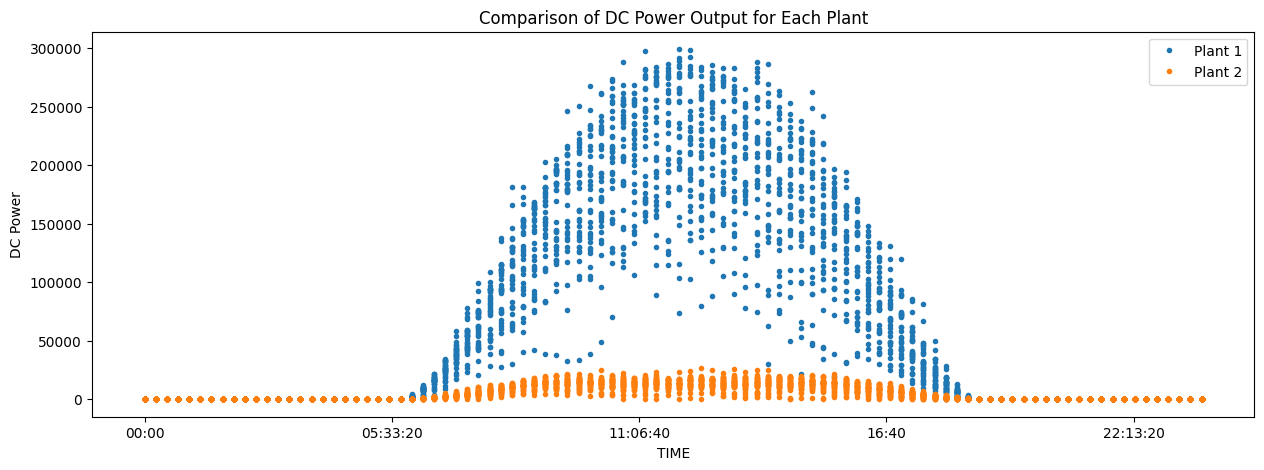

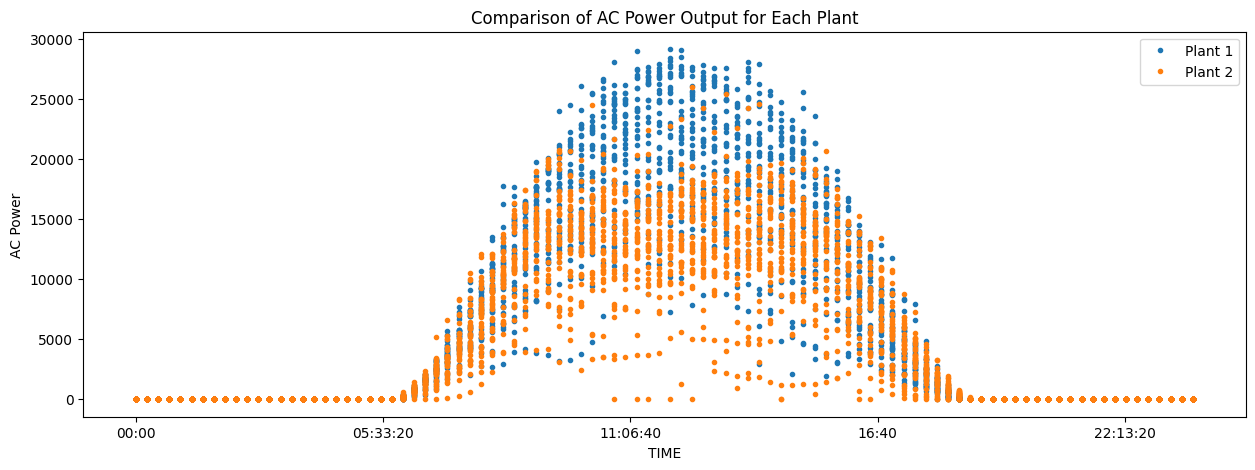

In [21]:
# DC output from solar module
fig, ax = plt.subplots(figsize=(15, 5))
plant1_generation_agg.plot(x='TIME', y='DC_POWER', style='.', label='Plant 1', ax=ax)
plant2_generation_agg.plot(x='TIME', y='DC_POWER', style='.', label='Plant 2', ax=ax)
plt.title('Comparison of DC Power Output for Each Plant')
plt.ylabel('DC Power')
plt.show()

# AC output from inverter
fig, ax = plt.subplots(figsize=(15, 5))
plant1_generation_agg.plot(x='TIME', y='AC_POWER', figsize=(15,5), legend=True, style='.', label='Plant 1', ax=ax)
plant2_generation_agg.plot(x='TIME', y='AC_POWER', legend=True, style='.', label='Plant 2', ax=ax)
plt.title('Comparison of AC Power Output for Each Plant')
plt.ylabel('AC Power')
plt.show()

- Plant 2 exhibits lower **DC power** output from its solar modules compared to Plant 1, nearly ten times less.
- Despite the more erratic nature of the **AC power** output from Plant 2, the levels of AC power output from both plants are similar.

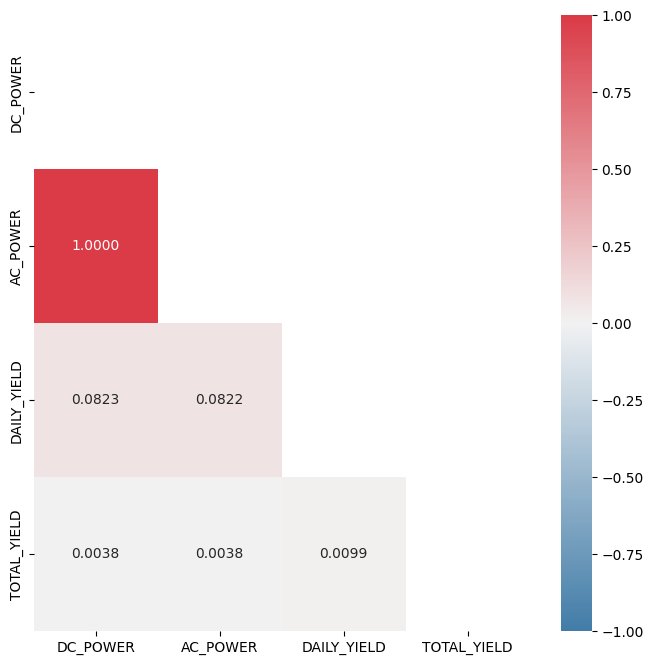

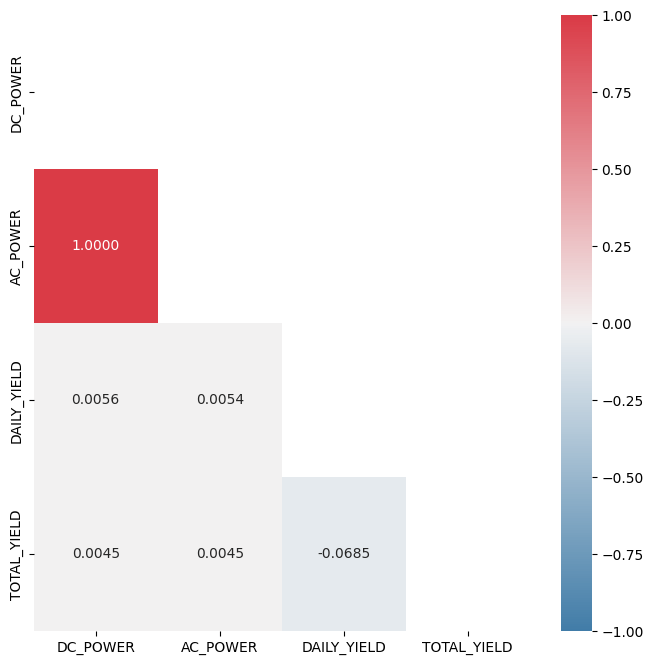

In [22]:
# Heatmap (corr pearson)

# Make new dataframe without ID column for each plant
gen1_corr = plant1_generation.drop('PLANT_ID', axis=1).corr(numeric_only=True, method='pearson')
gen2_corr = plant2_generation.drop('PLANT_ID', axis=1).corr(numeric_only=True, method='pearson')

# Plot correlation heatmap
gen1_mask = np.triu(np.ones_like(gen1_corr, dtype=bool))
gen2_mask = np.triu(np.ones_like(gen2_corr, dtype=bool))

plt.figure(figsize=(8,8))
cmap_custom = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(data = gen1_corr, cmap=cmap_custom, mask=gen1_mask, annot=True, fmt='.4f', vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(8,8))
cmap_custom = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(data = gen2_corr, cmap=cmap_custom, mask=gen2_mask, annot=True, fmt='.4f', vmin=-1, vmax=1)
plt.show()

* Correlation coefficient between DAILY_YIELD and output (AC_POWER and DC_POWER) for Plant 1 is higher than Plant 2.

# Further EDA on Sensor Data (Univariate and Bivariate)

In [23]:
plant1_sensor_agg

DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
0    2020-05-15 00:00:00            25.184316           22.857507   
1    2020-05-15 00:15:00            25.084589           22.761668   
2    2020-05-15 00:30:00            24.935753           22.592306   
3    2020-05-15 00:45:00            24.846130           22.360852   
4    2020-05-15 01:00:00            24.621525           22.165423   
...                  ...                  ...                 ...   
3177 2020-06-17 22:45:00            22.150570           21.480377   
3178 2020-06-17 23:00:00            22.129816           21.389024   
3179 2020-06-17 23:15:00            22.008275           20.709211   
3180 2020-06-17 23:30:00            21.969495           20.734963   
3181 2020-06-17 23:45:00            21.909288           20.427972   

      IRRADIATION      TIME        DATE  
0             0.0  00:00:00  2020-05-15  
1             0.0  00:15:00  2020-05-15  
2             0.0  00:30:00  2020-05-15  
3             0.0  00:45:00  2020-05-15  
4             0.0  01:00:00  2020-05-15  
...           ...       ...         ...  
3177          0.0  22:45:00  2020-06-17  
3178          0.0  23:00:00  2020-06-17  
3179          0.0  23:15:00  2020-06-17  
3180          0.0  23:30:00  2020-06-17  
3181          0.0  23:45:00  2020-06-17  

[3182 rows x 6 columns]

In [24]:
plant2_sensor_agg

DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
0    2020-05-15 00:00:00            27.004764           25.060789   
1    2020-05-15 00:15:00            26.880811           24.421869   
2    2020-05-15 00:30:00            26.682055           24.427290   
3    2020-05-15 00:45:00            26.500589           24.420678   
4    2020-05-15 01:00:00            26.596148           25.088210   
...                  ...                  ...                 ...   
3254 2020-06-17 22:45:00            23.511703           22.856201   
3255 2020-06-17 23:00:00            23.482282           22.744190   
3256 2020-06-17 23:15:00            23.354743           22.492245   
3257 2020-06-17 23:30:00            23.291048           22.373909   
3258 2020-06-17 23:45:00            23.202871           22.535908   

      IRRADIATION      TIME        DATE  
0             0.0  00:00:00  2020-05-15  
1             0.0  00:15:00  2020-05-15  
2             0.0  00:30:00  2020-05-15  
3             0.0  00:45:00  2020-05-15  
4             0.0  01:00:00  2020-05-15  
...           ...       ...         ...  
3254          0.0  22:45:00  2020-06-17  
3255          0.0  23:00:00  2020-06-17  
3256          0.0  23:15:00  2020-06-17  
3257          0.0  23:30:00  2020-06-17  
3258          0.0  23:45:00  2020-06-17  

[3259 rows x 6 columns]

<Figure size 1500x800 with 0 Axes>

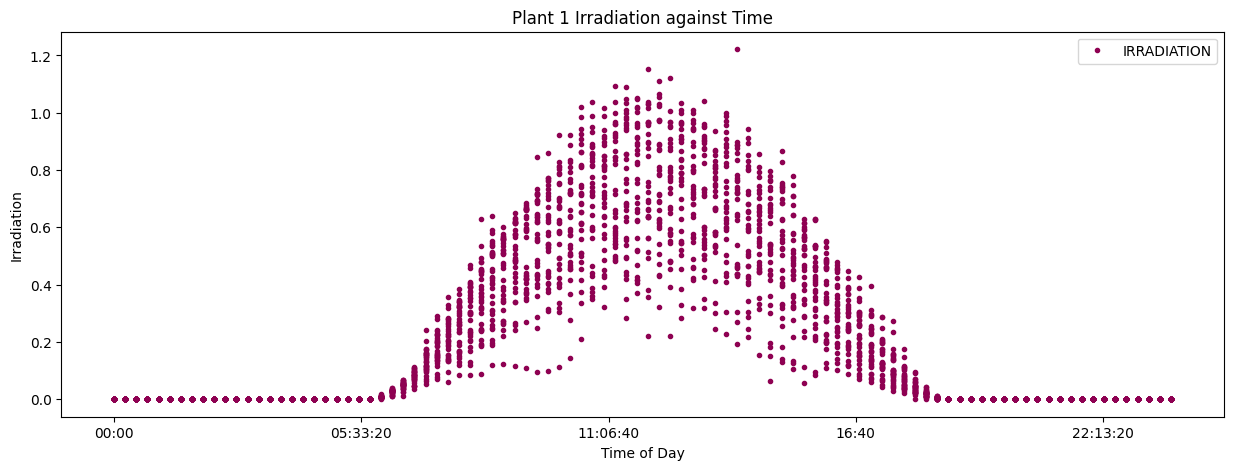

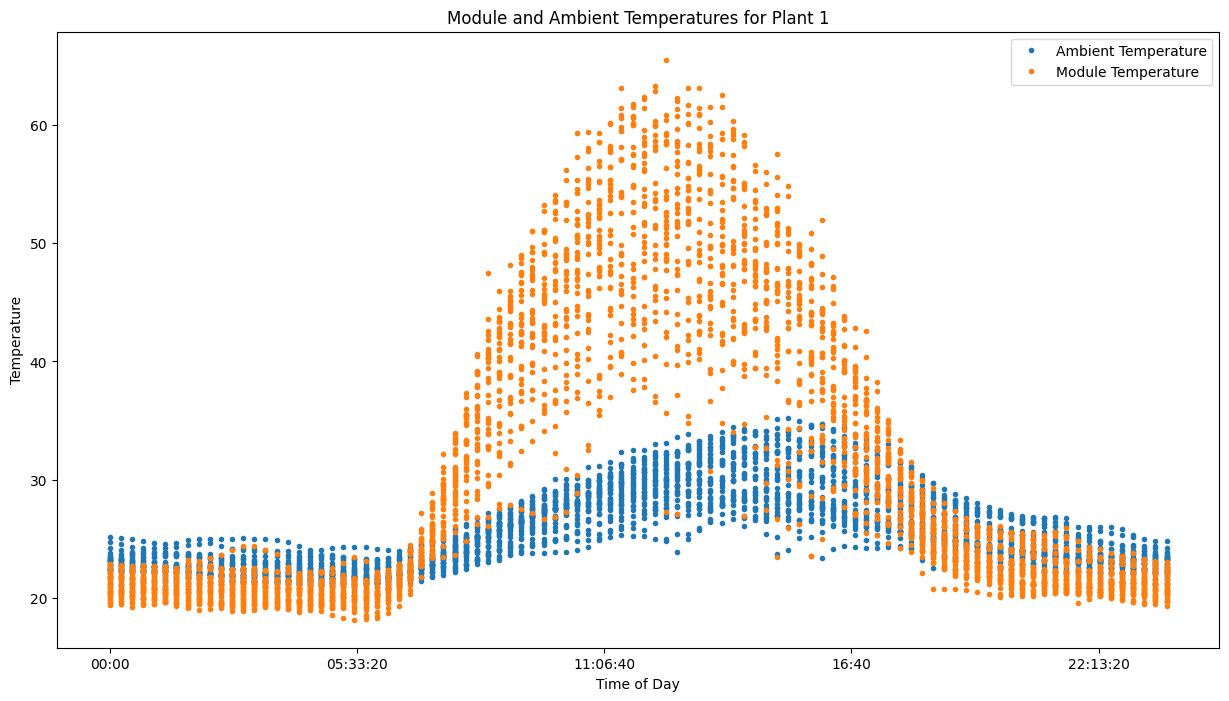

<Figure size 1500x800 with 0 Axes>

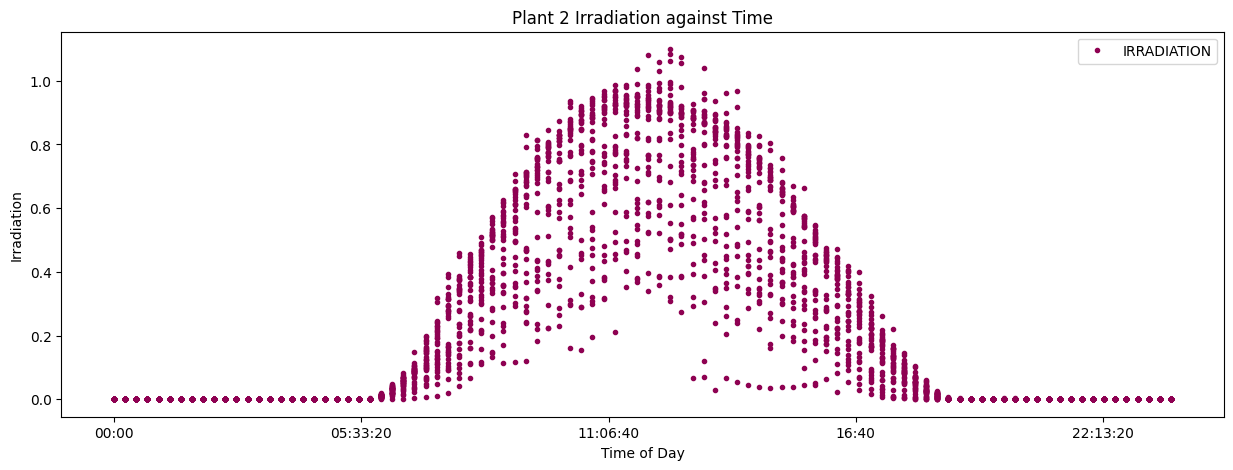

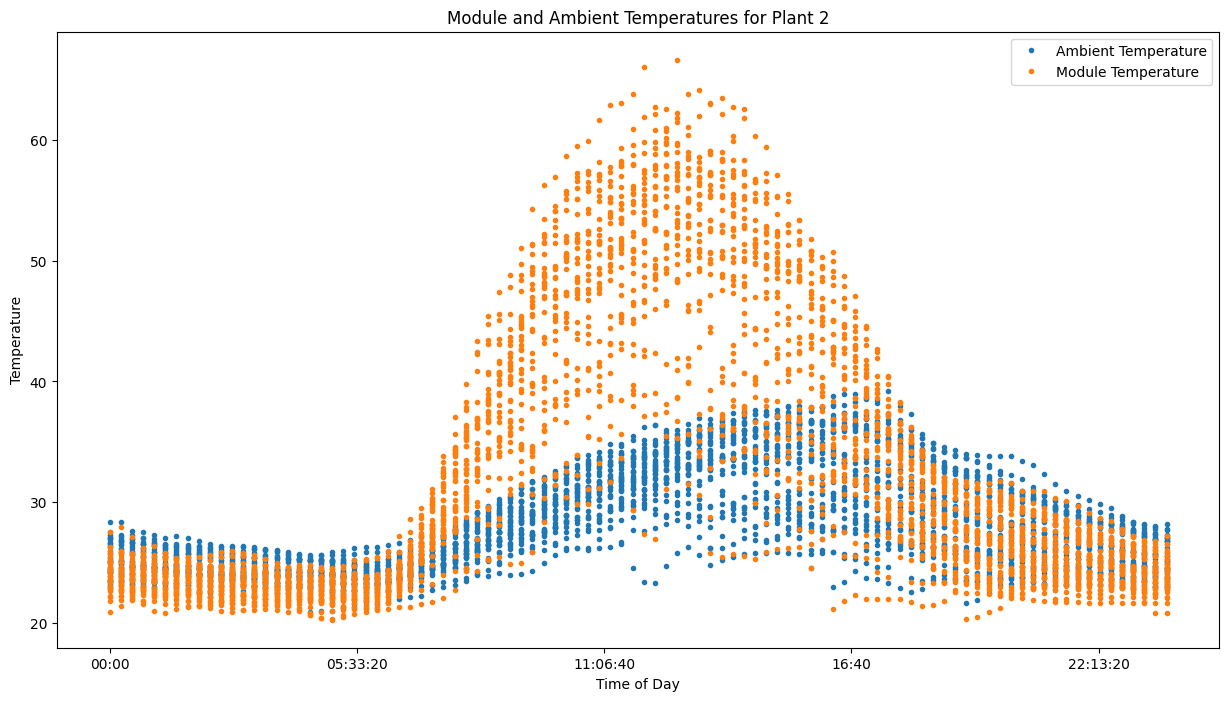

In [25]:
# Check Irradiation, Ambient Temperature, and Module Tmeperature againts time in a day for each Plant

# Plant 1

## Irradiation by time
plt.figure(figsize=(15,8))
plant1_sensor_agg.plot(x= 'TIME', y='IRRADIATION', style='.', figsize = (15, 5), colormap='PiYG')
plt.ylabel('Irradiation')
plt.xlabel('Time of Day')
plt.title('Plant 1 Irradiation against Time')
plt.show()

## Ambient and Module Temperature by time
fig, ax = plt.subplots(figsize=(15, 8))
plant1_sensor_agg.plot(x='TIME', y='AMBIENT_TEMPERATURE', style='.', label='Ambient Temperature', ax=ax)
plant1_sensor_agg.plot(x='TIME', y='MODULE_TEMPERATURE', style='.', label='Module Temperature', ax=ax)
plt.title('Module and Ambient Temperatures for Plant 1')
plt.xlabel('Time of Day')
plt.ylabel('Temperature')
plt.show()

# Plant 2

## Irradiation by time
plt.figure(figsize=(15,8))
plant2_sensor_agg.plot(x= 'TIME', y='IRRADIATION', style='.', figsize = (15, 5), colormap='PiYG')
plt.ylabel('Irradiation')
plt.xlabel('Time of Day')
plt.title('Plant 2 Irradiation against Time')
plt.show()

## Ambient and Module Temperature by time
fig, ax = plt.subplots(figsize=(15, 8))
plant2_sensor_agg.plot(x='TIME', y='AMBIENT_TEMPERATURE', style='.', label='Ambient Temperature', ax=ax)
plant2_sensor_agg.plot(x='TIME', y='MODULE_TEMPERATURE', style='.', label='Module Temperature', ax=ax)
plt.title('Module and Ambient Temperatures for Plant 2')
plt.xlabel('Time of Day')
plt.ylabel('Temperature')
plt.show()

* Ambient temperature goes down much later in the evening as compared to module temperature. This could mean that the specific heat capacity of the module is much lower than the specific heat capacity of the surrounding atmosphere making it took more energy to cool it down

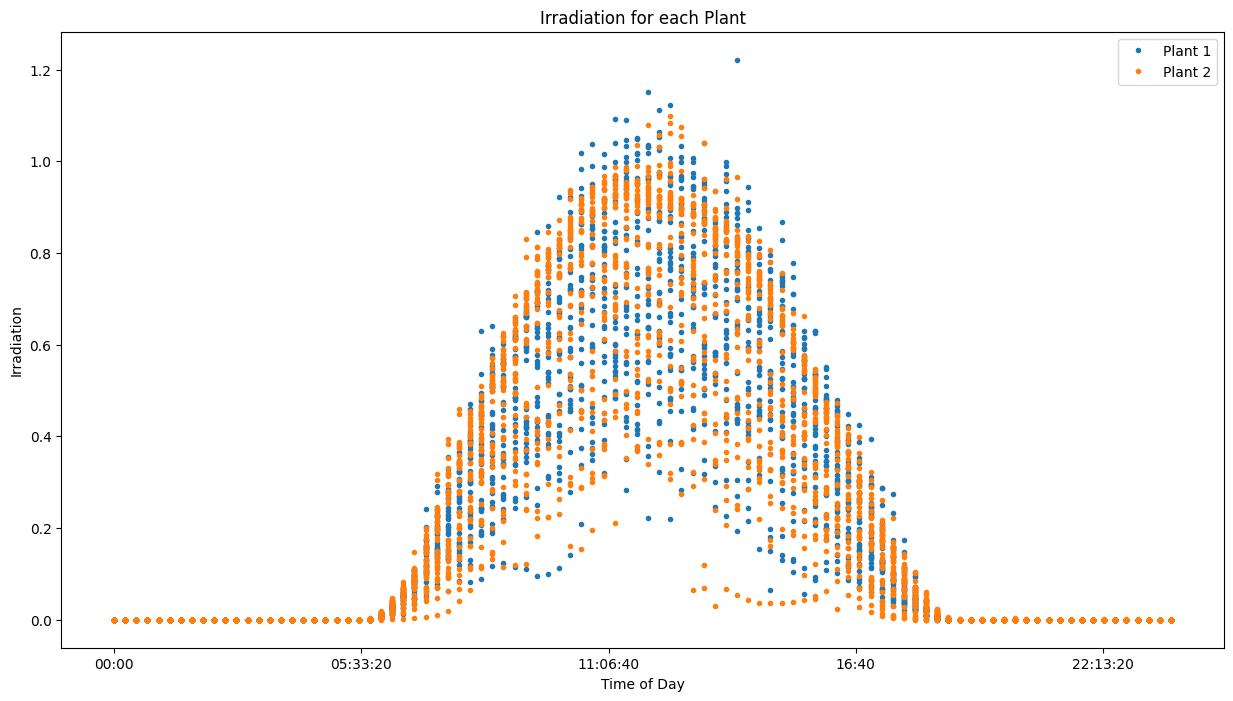

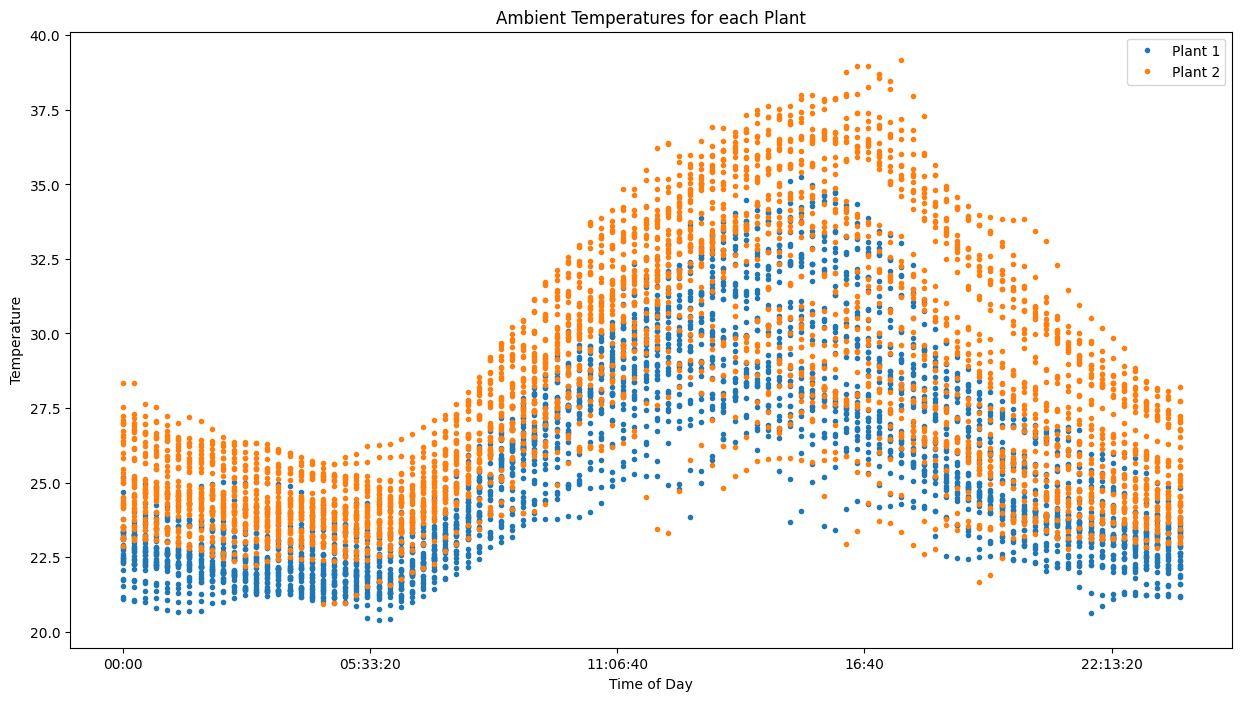

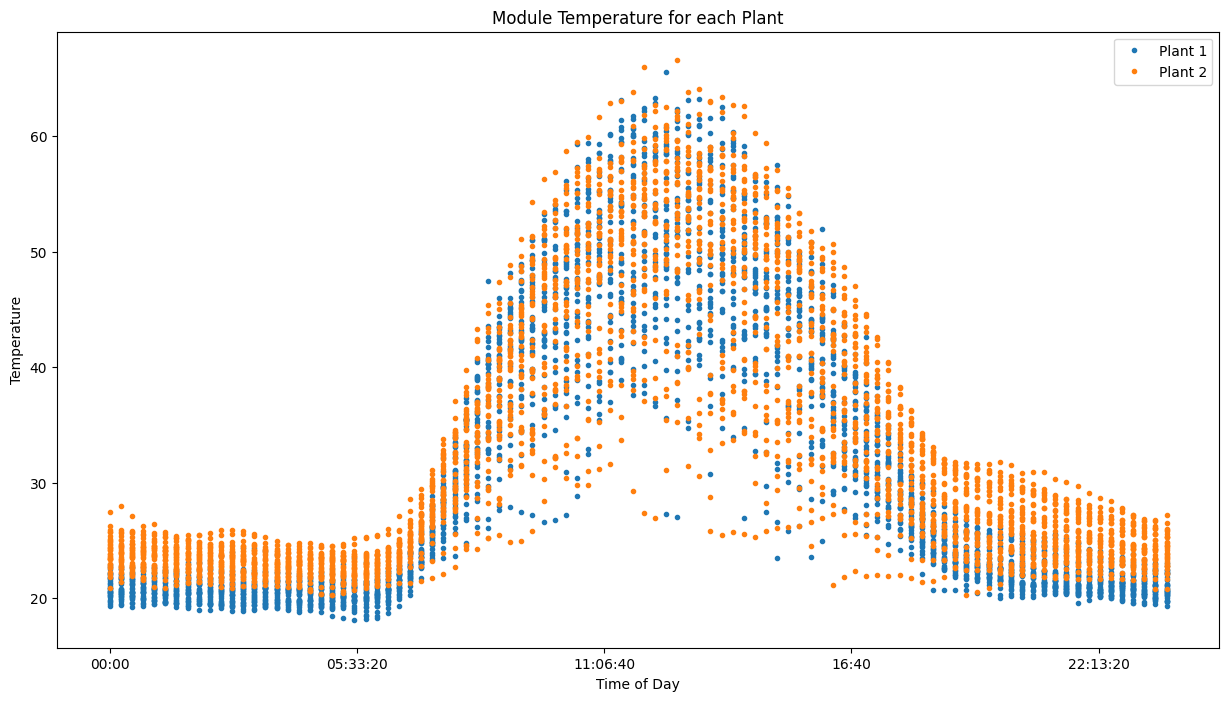

In [26]:
#  Comparison of Irradiation, Ambient Temperature, and Module Tmeperature againts time in a day for each Plant

## Irradiation by time
fig, ax = plt.subplots(figsize=(15, 8))
plant1_sensor_agg.plot(x='TIME', y='IRRADIATION', style='.', label='Plant 1', ax=ax)
plant2_sensor_agg.plot(x='TIME', y='IRRADIATION', style='.', label='Plant 2', ax=ax)
plt.title('Irradiation for each Plant')
plt.xlabel('Time of Day')
plt.ylabel('Irradiation')
plt.show()

## Ambient Temperature by time
fig, ax = plt.subplots(figsize=(15, 8))
plant1_sensor_agg.plot(x='TIME', y='AMBIENT_TEMPERATURE', style='.', label='Plant 1', ax=ax)
plant2_sensor_agg.plot(x='TIME', y='AMBIENT_TEMPERATURE', style='.', label='Plant 2', ax=ax)
plt.title('Ambient Temperatures for each Plant')
plt.xlabel('Time of Day')
plt.ylabel('Temperature')
plt.show()

## Module Temperature by time
fig, ax = plt.subplots(figsize=(15, 8))
plant1_sensor_agg.plot(x='TIME', y='MODULE_TEMPERATURE', style='.', label='Plant 1', ax=ax)
plant2_sensor_agg.plot(x='TIME', y='MODULE_TEMPERATURE', style='.', label='Plant 2', ax=ax)
plt.title('Module Temperature for each Plant')
plt.xlabel('Time of Day')
plt.ylabel('Temperature')
plt.show()

* Plant 2 has more extreme values/outliers in irradiation
* Plant 2 has higher ambient temperature values across all hours

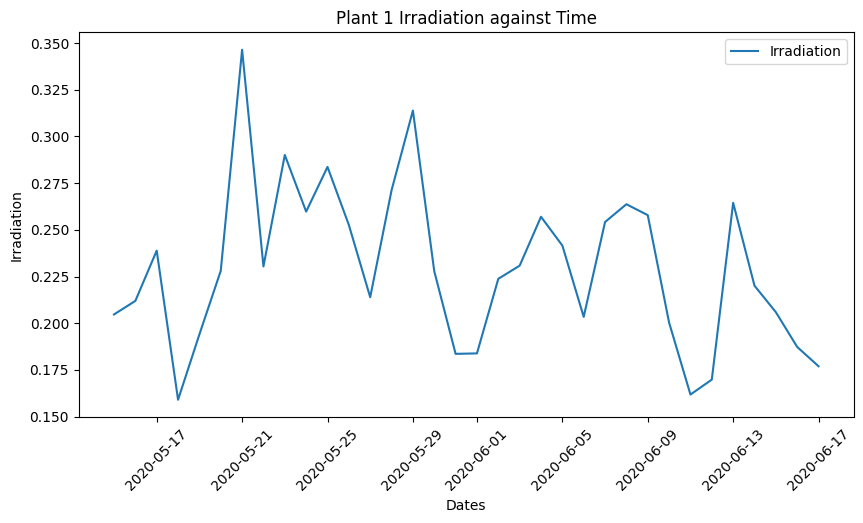

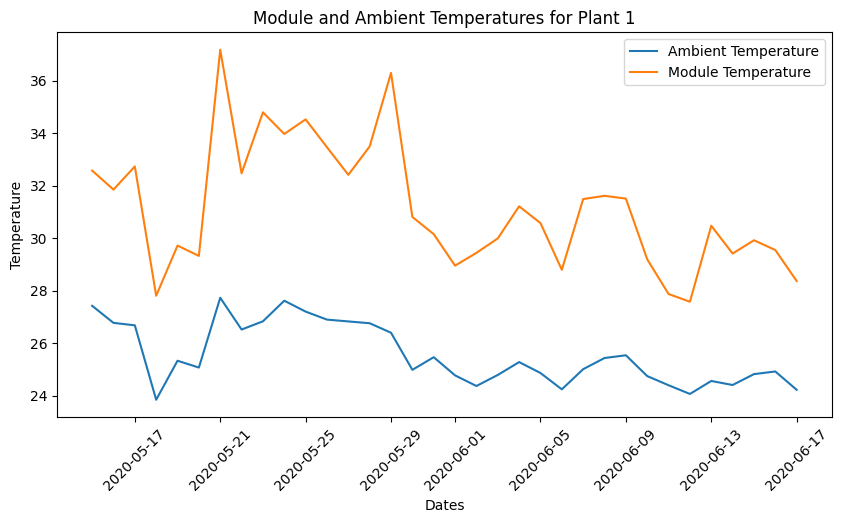

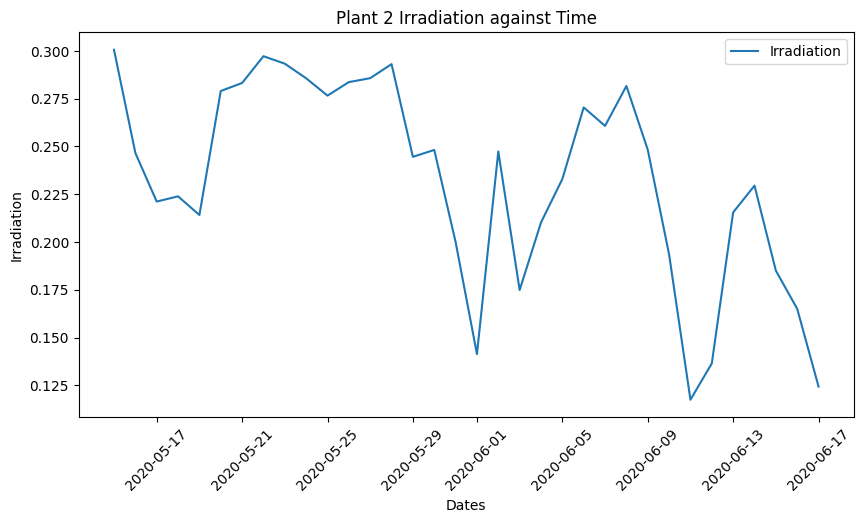

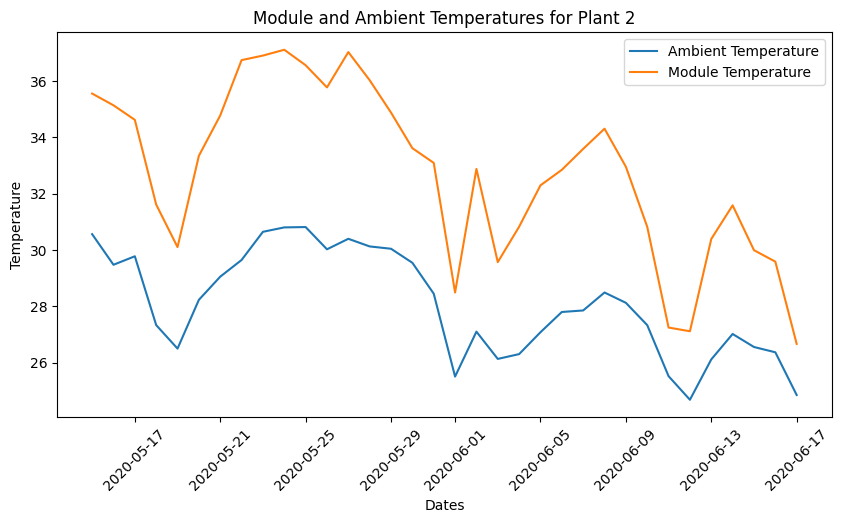

In [27]:
# Check Irradiation, Ambient Temperature, and Module Tmeperature againts time in a day for each Plant

# Plant 1

## Irradiation by dates
plt.figure(figsize=(10,5))
sns.lineplot(data=plant1_sensor_agg, x='DATE', y='IRRADIATION', err_style='band', label='Irradiation', ci=None)
plt.ylabel('Irradiation')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.title('Plant 1 Irradiation against Time')
plt.show()

## Ambient and Module Temperature by dates
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=plant1_sensor_agg, x='DATE', y='AMBIENT_TEMPERATURE', err_style='band', label='Ambient Temperature', ci=None)
sns.lineplot(data=plant1_sensor_agg, x='DATE', y='MODULE_TEMPERATURE', err_style='band', label='Module Temperature', ci=None)
plt.title('Module and Ambient Temperatures for Plant 1')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Temperature')
plt.show()

# Plant 2

## Irradiation by dates
plt.figure(figsize=(10,5))
sns.lineplot(data=plant2_sensor_agg, x='DATE', y='IRRADIATION', err_style='band', label='Irradiation', ci=None)
plt.ylabel('Irradiation')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.title('Plant 2 Irradiation against Time')
plt.show()

## Ambient and Module Temperature by dates
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=plant2_sensor_agg, x='DATE', y='AMBIENT_TEMPERATURE', err_style='band', label='Ambient Temperature', ci=None)
sns.lineplot(data=plant2_sensor_agg, x='DATE', y='MODULE_TEMPERATURE', err_style='band', label='Module Temperature', ci=None)
plt.title('Module and Ambient Temperatures for Plant 2')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Temperature')
plt.show()

As we can see that module temperature is always higher than ambient temperature

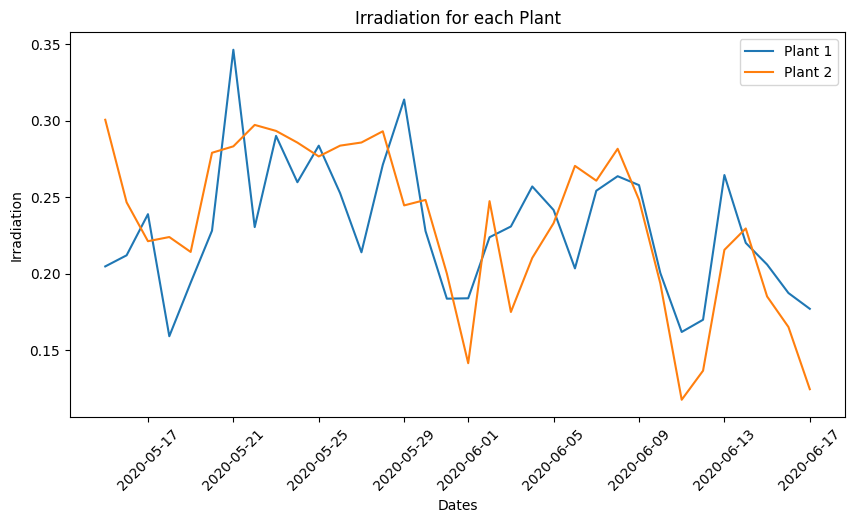

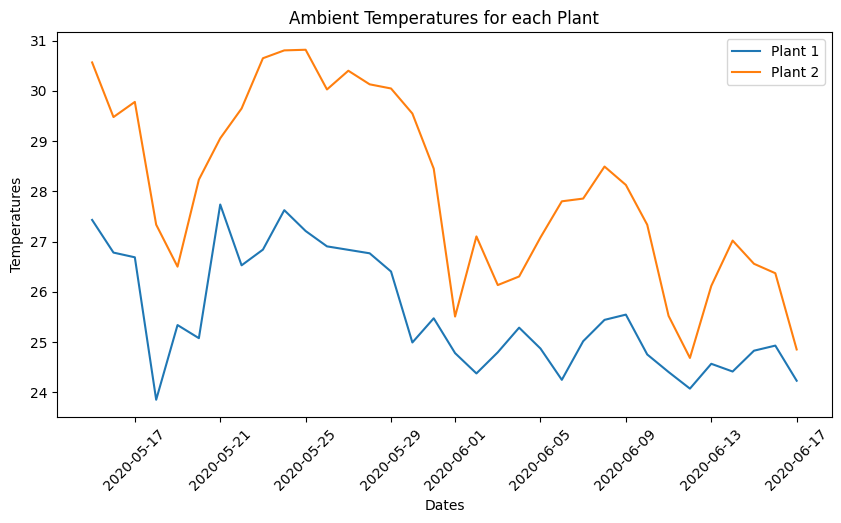

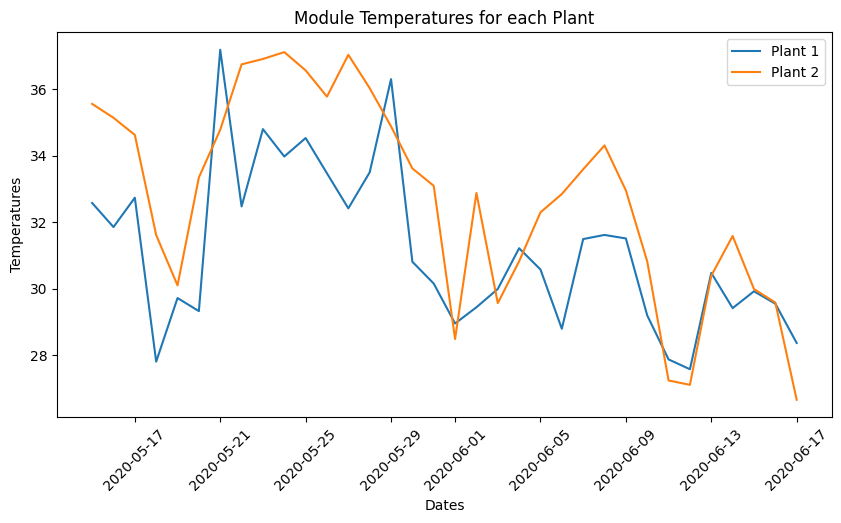

In [28]:
# Comparison of Irradiation, Ambient Temperature, and Module Tmeperature againts time in a day for each Plant

## Irradiation by dates
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=plant1_sensor_agg, x='DATE', y='IRRADIATION', err_style='band', label='Plant 1', ax=ax, ci=None)
sns.lineplot(data=plant2_sensor_agg, x='DATE', y='IRRADIATION', err_style='band', label='Plant 2', ax=ax, ci=None)
plt.title('Irradiation for each Plant')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Irradiation')
plt.show()

## Ambient Temperature by dates
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=plant1_sensor_agg, x='DATE', y='AMBIENT_TEMPERATURE', err_style='band', label='Plant 1', ax=ax, ci=None)
sns.lineplot(data=plant2_sensor_agg, x='DATE', y='AMBIENT_TEMPERATURE', err_style='band', label='Plant 2', ax=ax, ci=None)
plt.title('Ambient Temperatures for each Plant')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Temperatures')
plt.show()

## Module Temperature by dates
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=plant1_sensor_agg, x='DATE', y='MODULE_TEMPERATURE', err_style='band', label='Plant 1', ax=ax, ci=None)
sns.lineplot(data=plant2_sensor_agg, x='DATE', y='MODULE_TEMPERATURE', err_style='band', label='Plant 2', ax=ax, ci=None)
plt.title('Module Temperatures for each Plant')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Temperatures')
plt.show()

* Both plants exhibit similar mean solar irradiation values.
* Plant 1 generally maintains a slightly lower mean module temperature compared to Plant 2.
* The mean ambient temperature at Plant 1 is notably lower than that at Plant 2.
* Plant 1, situated in a colder region of India, is at a higher elevation compared to Plant 2, providing a plausible explanation for the similar solar irradiation levels.

# Merge Generation and Sensor Data For Each Plant

In [29]:
# Plant 1 merge data
plant1_merge = plant1_generation_agg.merge(plant1_sensor_agg, on=['DATE_TIME', 'DATE', 'TIME']).drop(columns=['DATE', 'TIME'])
plant1_merge.head(10)

DATE_TIME  DC_POWER  AC_POWER  AMBIENT_TEMPERATURE  \
0 2020-06-01 00:00:00       0.0       0.0            23.128673   
1 2020-06-01 00:15:00       0.0       0.0            23.032562   
2 2020-06-01 00:30:00       0.0       0.0            22.967493   
3 2020-06-01 00:45:00       0.0       0.0            22.810594   
4 2020-06-01 01:00:00       0.0       0.0            22.611436   
5 2020-06-01 01:15:00       0.0       0.0            22.497412   
6 2020-06-01 01:30:00       0.0       0.0            22.348948   
7 2020-06-01 01:45:00       0.0       0.0            22.151638   
8 2020-06-01 02:00:00       0.0       0.0            21.993119   
9 2020-06-01 02:15:00       0.0       0.0            21.974262   

   MODULE_TEMPERATURE  IRRADIATION  
0           20.464305          0.0  
1           20.341429          0.0  
2           20.269493          0.0  
3           20.198918          0.0  
4           20.085866          0.0  
5           20.263627          0.0  
6           20.201571          0.0  
7           20.045486          0.0  
8           19.941203          0.0  
9           20.068544          0.0

In [30]:
# Plant 2 merge data
plant2_merge = plant2_generation_agg.merge(plant2_sensor_agg, on=['DATE_TIME', 'DATE', 'TIME']).drop(columns=['DATE', 'TIME'])
plant2_merge.head(10)

DATE_TIME  DC_POWER  AC_POWER  AMBIENT_TEMPERATURE  \
0 2020-05-15 00:00:00       0.0       0.0            27.004764   
1 2020-05-15 00:15:00       0.0       0.0            26.880811   
2 2020-05-15 00:30:00       0.0       0.0            26.682055   
3 2020-05-15 00:45:00       0.0       0.0            26.500589   
4 2020-05-15 01:00:00       0.0       0.0            26.596148   
5 2020-05-15 01:15:00       0.0       0.0            26.512740   
6 2020-05-15 01:30:00       0.0       0.0            26.494339   
7 2020-05-15 01:45:00       0.0       0.0            26.420410   
8 2020-05-15 02:00:00       0.0       0.0            26.401946   
9 2020-05-15 02:15:00       0.0       0.0            26.226078   

   MODULE_TEMPERATURE  IRRADIATION  
0           25.060789          0.0  
1           24.421869          0.0  
2           24.427290          0.0  
3           24.420678          0.0  
4           25.088210          0.0  
5           25.317970          0.0  
6           25.217193          0.0  
7           25.065062          0.0  
8           24.691469          0.0  
9           24.559481          0.0

In building the model we wont need the DATE_TIME feature, so we will also drop that

In [31]:
# Drop DATE_TIME column
plant1_merge.drop(columns='DATE_TIME', inplace=True)
plant2_merge.drop(columns='DATE_TIME', inplace=True)

In [32]:
# Re-arrange the columns (AC_POWER in last)
df_1 = plant1_merge.drop(columns='AC_POWER')
df_2 = plant1_merge['AC_POWER']
plant1_merge = pd.concat([df_1, df_2], axis='columns')

df_1 = plant2_merge.drop(columns='AC_POWER')
df_2 = plant2_merge['AC_POWER']
plant2_merge = pd.concat([df_1, df_2], axis='columns')

# Feature Selection

<Figure size 1000x1000 with 0 Axes>

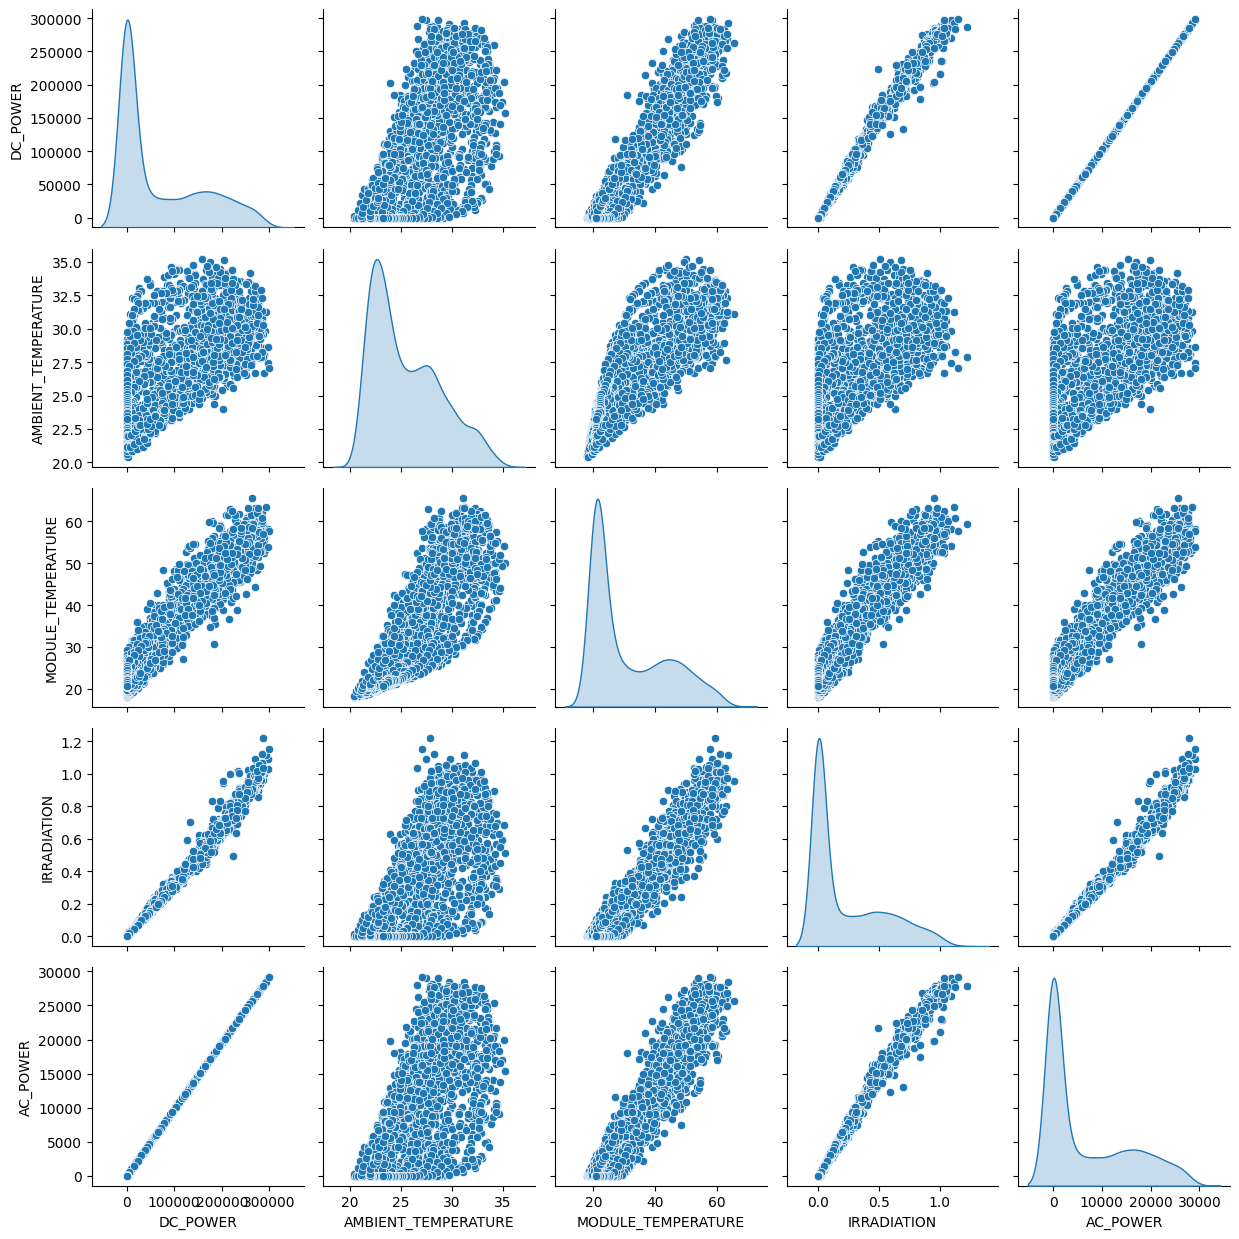

In [33]:
# Pairplot for Plant 1
plt.figure(figsize=(10, 10))
sns.pairplot(data=plant1_merge, diag_kind='kde')
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

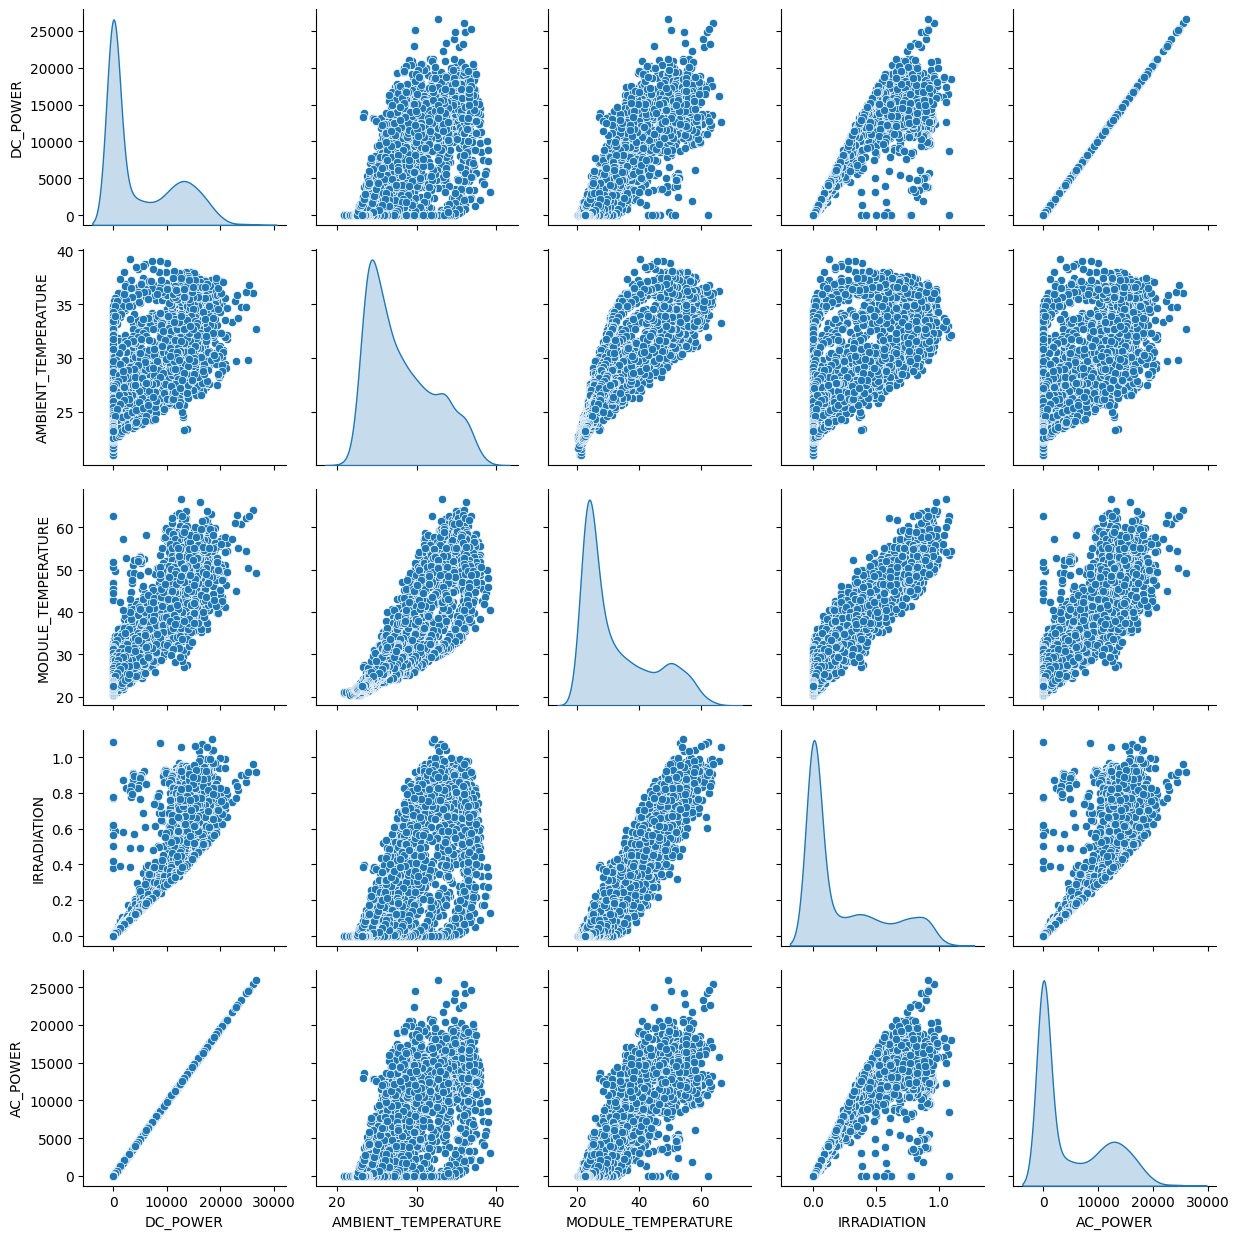

In [34]:
# Pairplot for Plant 2
plt.figure(figsize=(10, 10))
sns.pairplot(data=plant2_merge, diag_kind='kde')
plt.tight_layout()
plt.show()

## Checking correlation heatmap (Pearson method)

Let's check correlation and feature importance of features to target so that we can select relevant features in predicting AC Power

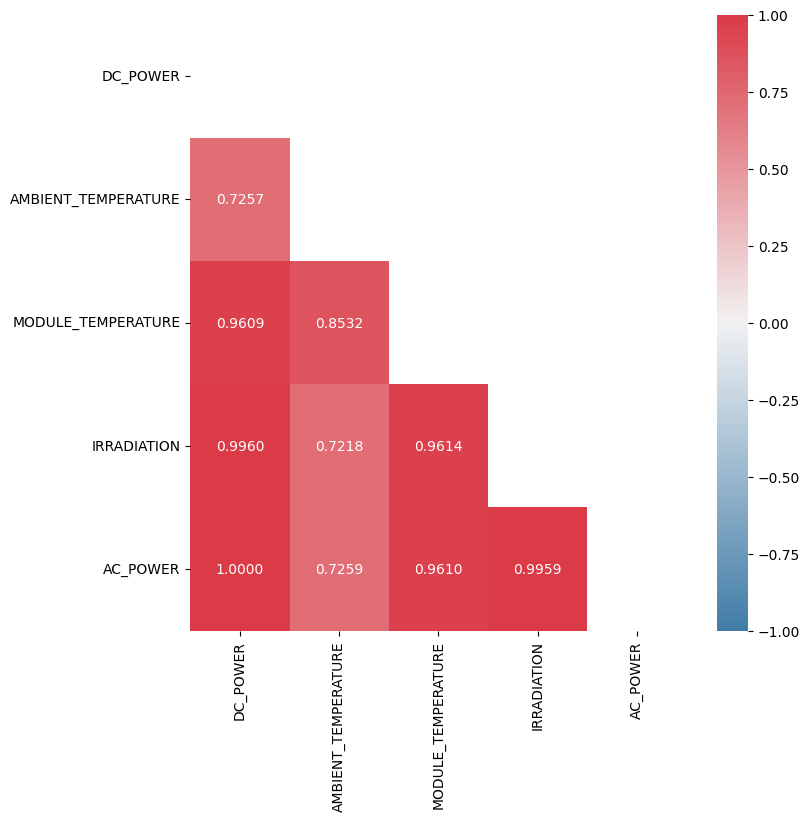

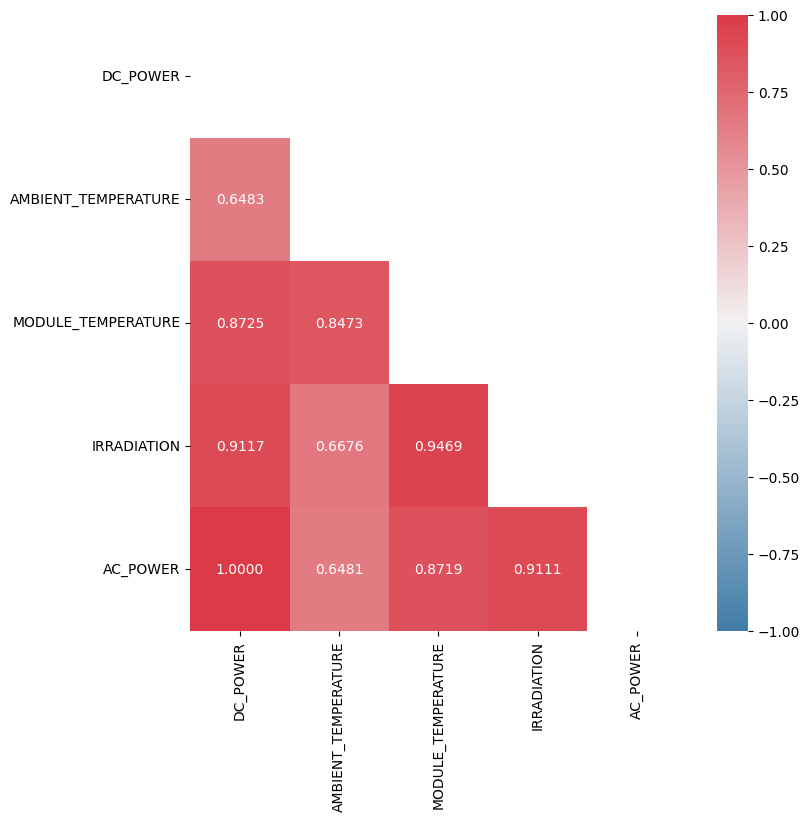

In [35]:
# Heatmap (corr pearson)

# Make new dataframe without ID column for each plant
merge1_corr = plant1_merge.corr(numeric_only=True, method='pearson')
merge2_corr = plant2_merge.corr(numeric_only=True, method='pearson')

# Plot correlation heatmap
merge1_mask = np.triu(np.ones_like(merge1_corr, dtype=bool))
merge2_mask = np.triu(np.ones_like(merge2_corr, dtype=bool))

plt.figure(figsize=(8, 8))
cmap_custom = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(data = merge1_corr, cmap=cmap_custom, mask=merge1_mask, annot=True, fmt='.4f', vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(8, 8))
cmap_custom = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(data = merge2_corr, cmap=cmap_custom, mask=merge2_mask, annot=True, fmt='.4f', vmin=-1, vmax=1)
plt.show()

## Checking feature importance using SelectKBest (Mutual information, and F-regression)

**Reminder About SelectKbest in Regression**

In scikit-learn, `f_regression` and `mutual_info_regression` are both methods for feature selection in regression problems, but they operate based on different principles.

1. **`f_regression`**:

   - **Methodology**: It uses the F-statistic to evaluate the linear dependency between each feature and the target variable. It assesses the linear relationship between each feature and the target, considering the overall variance explained by the model.

   - **Suitability**: It is appropriate when you expect linear relationships between your features and the target variable. If your features have linear correlation with the target, `f_regression` can be a suitable choice.

2. **`mutual_info_regression`**:

   - **Methodology**: It calculates the mutual information between each feature and the target. Mutual information measures the amount of information one variable contains about another. It can capture any type of statistical dependency, not limited to linear relationships.

   - **Suitability**: It is suitable when the relationship between the features and the target is not necessarily linear. If the relationship is more complex or non-linear, `mutual_info_regression` may provide better results.

**Choosing between them**:

- If you believe that the relationship between your features and the target is primarily linear, `f_regression` might be a good starting point.

- If you want to capture non-linear relationships or any form of statistical dependency, or if you are unsure about the nature of the relationships, you might consider using `mutual_info_regression`.

It's often a good practice to try both methods and compare their results or even combine them for a more comprehensive feature selection approach. Keep in mind that the effectiveness of these methods can also depend on the specific characteristics of your dataset.

In [36]:
# Calculation of feature importance score to target (numerical feature - numerical target)
from sklearn.feature_selection import SelectKBest, f_regression

# Separate features and target variable
x_features_test = plant1_merge.drop(columns=['AC_POWER'])  # Features
y_target_test = plant1_merge['AC_POWER']  # Target variable

# Instantiate SelectKBest
k_best = SelectKBest(score_func=f_regression, k='all')  # Use 'all' to see scores for all features

# Fit and transform the data
x_selected_features = k_best.fit_transform(x_features_test, y_target_test)

# Get scores, p-values, and feature names
feature_scores = k_best.scores_
p_values = k_best.pvalues_
feature_names = x_features_test.columns

# Create a DataFrame to display feature scores and p-values
feature_scores_df = pd.DataFrame({'Feature': feature_names, 'Score': feature_scores, 'P-value': p_values})
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Display the feature scores and p-values
print(feature_scores_df)

               Feature         Score  P-value
0             DC_POWER  5.623727e+08      0.0
3          IRRADIATION  3.790293e+05      0.0
2   MODULE_TEMPERATURE  3.810963e+04      0.0
1  AMBIENT_TEMPERATURE  3.513781e+03      0.0


In [37]:
#Calculation of feature importance score to target (numerical feature - numerical target)
from sklearn.feature_selection import SelectKBest, f_regression

# Separate features and target variable
x_features_test = plant2_merge.drop(columns=['AC_POWER'])  # Features
y_target_test = plant2_merge['AC_POWER']  # Target variable

# Instantiate SelectKBest
k_best = SelectKBest(score_func=f_regression, k='all')  # Use 'all' to see scores for all features

# Fit and transform the data
x_selected_features = k_best.fit_transform(x_features_test, y_target_test)

# Get scores, p-values, and feature names
feature_scores = k_best.scores_
p_values = k_best.pvalues_
feature_names = x_features_test.columns

# Create a DataFrame to display feature scores and p-values
feature_scores_df = pd.DataFrame({'Feature': feature_names, 'Score': feature_scores, 'P-value': p_values})
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Display the feature scores and p-values
print(feature_scores_df)

               Feature         Score  P-value
0             DC_POWER  4.413434e+08      0.0
3          IRRADIATION  1.591013e+04      0.0
2   MODULE_TEMPERATURE  1.032835e+04      0.0
1  AMBIENT_TEMPERATURE  2.358703e+03      0.0


**Reminder About P-Values**

In statistical hypothesis testing, the p-value is a measure that helps you assess the evidence against a null hypothesis. In the context of evaluating selected features for model training, p-values are often associated with statistical tests, such as t-tests or ANOVA, to determine whether there is a significant difference between groups.

Here's a general guideline:

1. **Null Hypothesis (\(H_0\)):** The null hypothesis typically assumes that there is no significant relationship or difference between groups.
   
2. **Alternative Hypothesis (\(H_1\) or \(H_a\)):** The alternative hypothesis suggests that there is a significant relationship or difference.

3. **P-value Interpretation:**
   - If the p-value is less than or equal to your chosen significance level (often 0.05), you reject the null hypothesis. This suggests that there is enough evidence to conclude that there is a significant relationship or difference.
   - If the p-value is greater than your chosen significance level, you fail to reject the null hypothesis. This implies that there is not enough evidence to conclude a significant relationship or difference.

However, it's crucial to note a few considerations:

- **Multiple Comparisons:** When you're evaluating multiple features simultaneously, there is a risk of inflated Type I error (false positives) due to multiple comparisons. In such cases, you might want to apply a correction method (like Bonferroni correction) to adjust the significance level.

- **Effect Size:** Even if a result is statistically significant, it might not be practically significant. Therefore, it's important to consider the effect size along with p-values.

- **Domain Knowledge:** Statistical significance does not guarantee practical importance. Consider the context and domain-specific knowledge when interpreting results.

- **Model Performance:** P-values alone might not be sufficient for feature selection. It's crucial to also consider how well the selected features contribute to the overall performance of your predictive model.

In summary, while a commonly used threshold is a p-value less than 0.05, the interpretation should be made in the context of your study, and it's essential to consider additional factors like effect size, domain knowledge, and overall model performance.

In [38]:
# Select only relevant features
plant1_model = plant1_merge.copy()
plant2_model = plant2_merge.copy()

selected_features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'AC_POWER']

plant1_model = plant1_model[selected_features]
plant2_model = plant2_model[selected_features]

# Train-Test Split

## Train-Test Split Plant 1

In [39]:
# Spliting data into train-test
X1 = plant1_model.drop(columns=['AC_POWER'])
y1 = plant1_model[['AC_POWER']]

from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

## Train-Test Split Plant 2

In [40]:
# Spliting data into train-test
X2 = plant2_model.drop(columns=['AC_POWER'])
y2 = plant2_model[['AC_POWER']]

from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

# Handle Outliers

In [42]:
# Make temporary dataframe of features and target for train set
plant1_handling_outliers = pd.concat([X1_train, y1_train], axis='columns')
plant2_handling_outliers = pd.concat([X2_train, y2_train], axis='columns')

In [44]:
columns_to_handle_outliers = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

Plant 1 Distribution


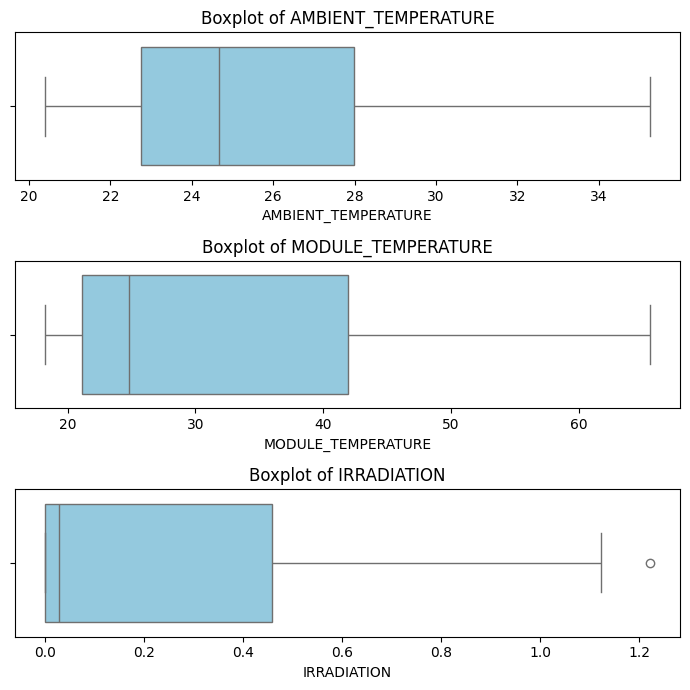

Plant 2 Distribution


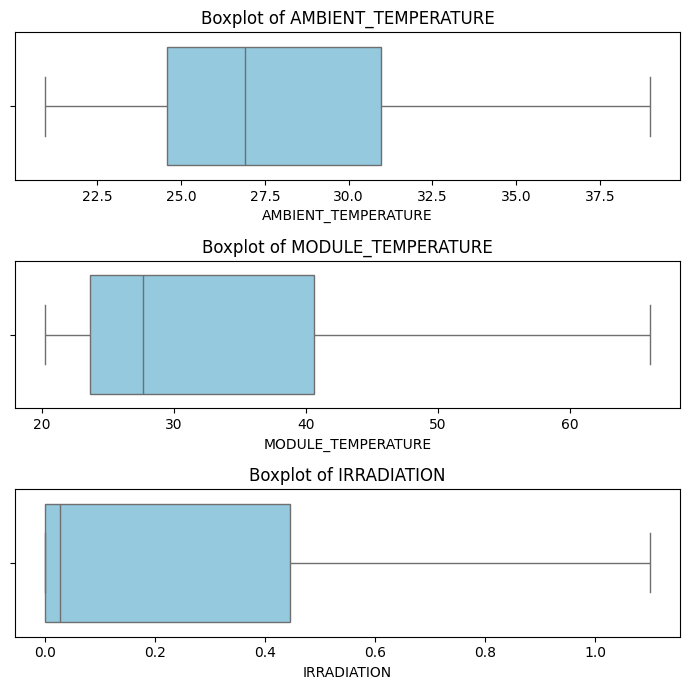

In [50]:
# Boxplot before handling outliers
for i, plant in enumerate([plant1_handling_outliers, plant2_handling_outliers], 1):
  fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 7))
  axes = axes.flatten()

  print(f"Plant {i} Distribution")

  for i in range(len(columns_to_handle_outliers)):
    sns.boxplot(data = plant, ax=axes[i], x=columns_to_handle_outliers[i], orient='h', color='skyblue')
    axes[i].set_title(f'Boxplot of {columns_to_handle_outliers[i]}')

  # Remove the last subplot if there are fewer features than subplots
  if len(columns_to_handle_outliers) < len(axes):
      axes[len(columns_to_handle_outliers)].remove()

  plt.tight_layout()
  plt.show()

In total, there is actually only 1 data point that have outlier here on Plant 1 and the value is not that far/extreme either, but just to be safe let's just handle that using IQR 

In [51]:
# Remove outliers with IQR method

print(f'The number of rows before filtering out outliers : {len(plant1_handling_outliers)}')

filtered_entries = np.array([True] * len(plant1_handling_outliers))

# Select features with outliers
for col in columns_to_handle_outliers:

    Q1 = plant1_handling_outliers[col].quantile(0.25)
    Q3 = plant1_handling_outliers[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (IQR * 1.5)
    upper_bound = Q3 + (IQR * 1.5)

    filtered_entries = ((plant1_handling_outliers[col] >= lower_bound) & (plant1_handling_outliers[col] <= upper_bound)) & filtered_entries

df_train_handling_outliers = plant1_handling_outliers[filtered_entries]

print(f'The number of rows after filtering out outliers: {len(df_train_handling_outliers)}')

The number of rows before filtering out outliers : 2209
The number of rows after filtering out outliers: 2208


In [52]:
# # Remove outliers with z-score method

# import scipy.stats as st

# print(f'The number of rows before filtering out outliers : {len(plant1_handling_outliers)}')

# filtered_entries = np.array([True] * len(plant1_handling_outliers))

# # Select features with outliers
# for col in columns_to_handle_outliers:
#     zscore = abs(stats.zscore(plant1_handling_outliers[col])) # calculate the absolute z-score
#     filtered_entries = (zscore < 3) & filtered_entries # keep z-score values less than absolute 3
    
# plant1_handling_outliers = plant1_handling_outliers[filtered_entries]

# print(f'The number of rows after filtering out outliers: {len(plant1_handling_outliers)}')

In [52]:
# Split the features and target for train set again
X1_train = df_train_handling_outliers.drop(columns='AC_POWER')
y1_train = df_train_handling_outliers['AC_POWER']

# Feature Scaling

Scaling will be done to train and test data

In [53]:
X1_train

AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
748             25.647653           23.230061     0.000000
2581            34.310097           46.149711     0.306096
662             23.465310           21.887561     0.000000
480             22.446710           19.740186     0.000000
803             26.633242           45.439112     0.650318
...                   ...                 ...          ...
3092            23.244623           26.083354     0.152250
1095            24.942493           36.774971     0.390469
1130            25.324770           24.317898     0.000143
1294            25.923041           38.486489     0.426235
860             22.892314           20.571364     0.000000

[2208 rows x 3 columns]

X1 Train Distribution


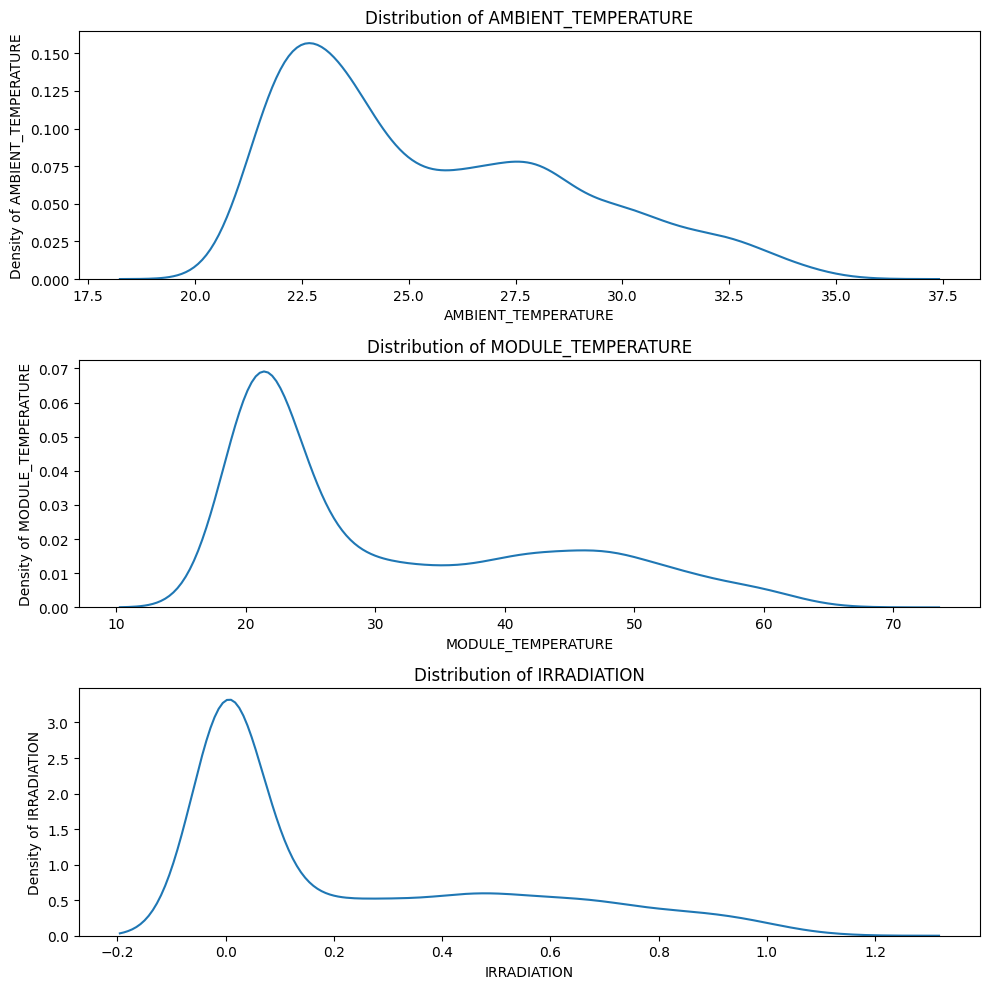

X2 Train Distribution


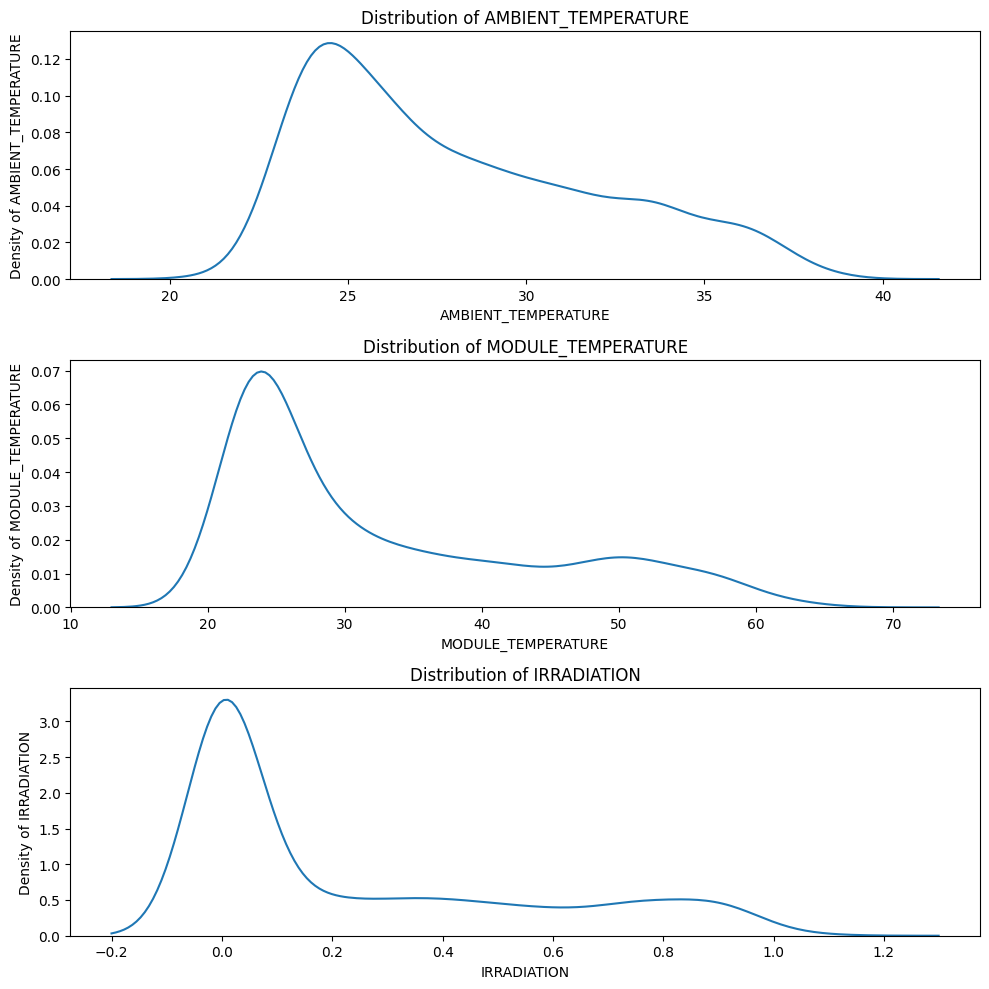

In [54]:
# Checking distribution before scaling
for i, train in enumerate([X1_train, X2_train], 1):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
    axes = axes.flatten()

    print(f"X{i} Train Distribution")

    for i in range(len(train.columns)) :
        sns.kdeplot(data = train, ax=axes[i], x=train.columns[i])
        axes[i].set_title(f'Distribution of {train.columns[i]}')
        axes[i].set_ylabel(f'Density of {train.columns[i]}')
        axes[i].set_xlabel(f'{train.columns[i]}')

    # Remove the last subplot if there are fewer features than subplots
    if len(train.columns) < len(axes) :
        axes[len(train.columns)].remove()

    plt.tight_layout()
    plt.show()

All of feature distribution are right/positive skewed, so as for now we will try to use min-max scaler

In [55]:
# Normalization (MinMaxScaller)
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()

columns_to_scale = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

X1_train[columns_to_scale] = ms.fit_transform(X1_train[columns_to_scale])
X1_test[columns_to_scale] = ms.transform(X1_test[columns_to_scale])

X2_train[columns_to_scale] = ms.fit_transform(X2_train[columns_to_scale])
X2_test[columns_to_scale] = ms.transform(X2_test[columns_to_scale])

In [58]:
# #Standardization (Z-score normalization)
# from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()

# columns_to_scale = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

# x1_train[columns_to_scale] = ss.fit_transform(x1_train[columns_to_scale])
# x1_test[columns_to_scale] = ss.transform(x1_test[columns_to_scale])

# x2_train[columns_to_scale] = ss.fit_transform(x2_train[columns_to_scale])
# x2_test[columns_to_scale] = ss.transform(x2_test[columns_to_scale])

# Modelling

## Helper Function

In [58]:
# Import metrics score that will be evalueated
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_validate, RepeatedKFold

#Function for model evaluation metrics score
def eval_regression(
    model,
    X_test,
    y_test,
    X_train,
    y_train,
    custom_metrics=None,
    n_splits=5,
    n_repeats=3,
    random_state=42
) -> dict:
    """
    Comprehensively evaluate a regression model using multiple metrics 
    and cross-validation techniques.

    Parameters:
    -----------
    model : sklearn estimator
        The regression model to be evaluated
    X_test : array-like
        Test feature dataset
    y_test : array-like
        Test target values
    X_train : array-like
        Training feature dataset
    y_train : array-like
        Training target values
    custom_metrics : dict, optional (default=None)
        Additional custom metric functions to evaluate
        Format: {'metric_name': metric_function}
    n_splits : int, optional (default=5)
        Number of splits for cross-validation
    n_repeats : int, optional (default=3)
        Number of times to repeat cross-validation
    random_state : int, optional (default=42)
        Seed for reproducibility of cross-validation splits

    Returns:
    --------
    dict
        Comprehensive dictionary of model performance metrics
    """
    try:
        # Utility function to convert input to numpy array
        def to_numpy(arr):
            """Convert pandas DataFrame/Series to numpy array if necessary."""
            if isinstance(arr, (pd.DataFrame, pd.Series)):
                return arr.to_numpy()
            return arr

        # Convert all input data to numpy arrays
        X_test = to_numpy(X_test)
        y_test = to_numpy(y_test)
        X_train = to_numpy(X_train)
        y_train = to_numpy(y_train)

        # Initialize metrics dictionary to store all evaluation results
        metrics = {}

        # Perform single-run predictions on test and train datasets
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        # Setup cross-validation strategy
        cv = RepeatedKFold(
            n_splits=n_splits,
            n_repeats=n_repeats,
            random_state=random_state
        )

        # Define standard metrics to evaluate
        scoring = {
            'mae': 'neg_mean_absolute_error',
            'rmse': 'neg_root_mean_squared_error',
            'r2': 'r2'
        }

        # Add MAPE as a custom scorer (not built-in to sklearn)
        def mape_scorer(estimator, X, y):
            y_pred = estimator.predict(X)
            return -mean_absolute_percentage_error(y, y_pred)  # Negative for sklearn's scoring convention
        
        # Perform cross-validation with multiple metrics
        cv_scores = cross_validate(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring={**scoring, 'mape': mape_scorer},
            return_train_score=True,
            n_jobs=-1  # Use all available CPU cores
        )

        # Store cross-validated metrics
        metrics['cv'] = {}

        # Process each metric from cross-validation
        for metric in list(scoring.keys()) + ['mape']:
            test_scores = cv_scores[f'test_{metric}']
            train_scores = cv_scores[f'train_{metric}']
            
            # For negative metrics, convert back to positive
            if metric in ['mae', 'rmse', 'mape']:
                test_scores = -test_scores
                train_scores = -train_scores

            # Store mean and standard deviation of cross-validated scores
            metrics['cv'][metric] = {
                'test_mean': test_scores.mean(),
                'test_std': test_scores.std(),
                'train_mean': train_scores.mean(),
                'train_std': train_scores.std()
            }

        # Store single-run metrics
        metrics['mae'] = {
            'test': mean_absolute_error(y_test, y_pred_test),
            'train': mean_absolute_error(y_train, y_pred_train)
        }
        
        metrics['rmse'] = {
            'test': mean_squared_error(y_test, y_pred_test, squared=False),
            'train': mean_squared_error(y_train, y_pred_train, squared=False)
        }
        
        metrics['mape'] = {
            'test': mean_absolute_percentage_error(y_test, y_pred_test),
            'train': mean_absolute_percentage_error(y_train, y_pred_train)
        }
        
        metrics['r2'] = {
            'test': r2_score(y_test, y_pred_test),
            'train': r2_score(y_train, y_pred_train)
        }

        # Add custom metrics if provided
        if custom_metrics:
            for metric_name, metric_func in custom_metrics.items():
                metrics[metric_name] = {
                    'test': metric_func(y_test, y_pred_test),
                    'train': metric_func(y_train, y_pred_train)
                }

        # Print results
        print(f"Performance Metrics for {model.__class__.__name__}:")
        print("\nCross-Validated Metrics (mean ± std):")
        for metric in metrics['cv'].keys():
            print(f"\n{metric.upper()}:")
            if metric == 'r2':
                print(f"  Test:  {metrics['cv'][metric]['test_mean']:.4f} ± {metrics['cv'][metric]['test_std']:.4f}")
                print(f"  Train: {metrics['cv'][metric]['train_mean']:.4f} ± {metrics['cv'][metric]['train_std']:.4f}")
            else:
                print(f"  Test:  {metrics['cv'][metric]['test_mean']:.4f} ± {metrics['cv'][metric]['test_std']:.4f}")
                print(f"  Train: {metrics['cv'][metric]['train_mean']:.4f} ± {metrics['cv'][metric]['train_std']:.4f}")

        print("\nSingle Run Metrics:")
        for metric in metrics.keys():
            if metric != 'cv':
                print(f"\n{metric.upper()}:")
                print(f"  Test:  {metrics[metric]['test']:.4f}")
                print(f"  Train: {metrics[metric]['train']:.4f}")

        return metrics

    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        raise

## Train Regression Models

In [56]:
# Check the amount of training and test data for Plant 1
print(f'Rows of training data : {len(X1_train)}')
print(f'Rows of test data : {len(X1_test)}')

Rows of training data : 2208
Rows of test data : 948


In [57]:
# Check the amount of training and test data for Plant 2
print(f'Rows of training data : {len(X2_train)}')
print(f'Rows of test data : {len(X2_test)}')

Rows of training data : 2281
Rows of test data : 978


Unfortunetly, The amount of training and test data in this case is quite low, so i don't think we will get an optimal result. But we will just see the result for now

In [59]:
# Import models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialize models for Plant 1
lr1 = LinearRegression()
ridge1 = Ridge()
lasso1 = Lasso()
elasticnet1 = ElasticNet()
knn1 = KNeighborsRegressor()
dt1 = DecisionTreeRegressor(random_state=42)
rf1 = RandomForestRegressor(random_state=42)
xgb1 = XGBRegressor(random_state=42)

# Initialize models for Plant 2
lr2 = LinearRegression()
ridge2 = Ridge()
lasso2 = Lasso()
elasticnet2 = ElasticNet()
knn2 = KNeighborsRegressor()
dt2 = DecisionTreeRegressor(random_state=42)
rf2 = RandomForestRegressor(random_state=42)
xgb2 = XGBRegressor(random_state=42)

# Group models
models1 = [lr1, ridge1, lasso1, elasticnet1, knn1, dt1, rf1, xgb1]
models2 = [lr2, ridge2, lasso2, elasticnet2, knn2, dt2, rf2, xgb2]

# Train models for Plant 1
for model in models1:
    model.fit(X1_train, y1_train)

# Train models for Plant 2
for model in models2:
    model.fit(X2_train, y2_train)

## Model Evaluation

- As for now this is separated for plant 1 and 2, i will change it later to combine in 1 function.

- Lower values of MAE, MSE, and RMSE generally indicate higher precision, with RMSE values interpreted in kilowatts (kW) serving as our primary metric, but i'm kinda curious about R2 score so we will also evaluate than on cross validation

### Plant 1

#### Linear Regression

In [60]:
results_lr1 = eval_regression(lr1, X1_test, y1_test, X1_train, y1_train)

Performance Metrics for LinearRegression:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  437.8965 ± 24.7485
  Train: 436.2394 ± 7.9897

RMSE:
  Test:  776.7603 ± 64.6163
  Train: 776.5639 ± 16.1661

R2:
  Test:  0.9919 ± 0.0014
  Train: 0.9920 ± 0.0003

MAPE:
  Test:  303925024681742400.0000 ± 15495459166066262.0000
  Train: 303191716618048704.0000 ± 8877050216368012.0000

Single Run Metrics:

MAE:
  Test:  433.9488
  Train: 436.4156

RMSE:
  Test:  737.1512
  Train: 776.9977

MAPE:
  Test:  297684828889588288.0000
  Train: 303461390432498048.0000

R2:
  Test:  0.9924
  Train: 0.9920


#### Ridge Regression

In [61]:
results_ridge1 = eval_regression(ridge1, X1_test, y1_test, X1_train, y1_train)

Performance Metrics for Ridge:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  462.2283 ± 20.9698
  Train: 460.6419 ± 7.5535

RMSE:
  Test:  803.1813 ± 59.1036
  Train: 802.3337 ± 15.3050

R2:
  Test:  0.9913 ± 0.0013
  Train: 0.9914 ± 0.0003

MAPE:
  Test:  334788615983960768.0000 ± 18924897439073332.0000
  Train: 334028384281803200.0000 ± 9506206047043904.0000

Single Run Metrics:

MAE:
  Test:  447.9860
  Train: 454.1412

RMSE:
  Test:  744.3749
  Train: 795.9472

MAPE:
  Test:  322087591846591744.0000
  Train: 326607240671104448.0000

R2:
  Test:  0.9922
  Train: 0.9916


#### Lasso Regression

In [62]:
results_lasso1 = eval_regression(lasso1, X1_test, y1_test, X1_train, y1_train)

Performance Metrics for Lasso:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  439.0433 ± 24.6810
  Train: 437.6683 ± 8.0408

RMSE:
  Test:  776.4844 ± 64.5737
  Train: 776.6029 ± 16.1683

R2:
  Test:  0.9919 ± 0.0014
  Train: 0.9920 ± 0.0003

MAPE:
  Test:  309431919238211648.0000 ± 15493648896931026.0000
  Train: 308917712931403712.0000 ± 8575377254549922.0000

Single Run Metrics:

MAE:
  Test:  435.1127
  Train: 437.7697

RMSE:
  Test:  736.9223
  Train: 777.0376

MAPE:
  Test:  303553440599959104.0000
  Train: 309507516222994304.0000

R2:
  Test:  0.9924
  Train: 0.9920


#### Elasticnet Regression

In [63]:
results_elasticnet1 = eval_regression(elasticnet1, X1_test, y1_test, X1_train, y1_train)

Performance Metrics for ElasticNet:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  5735.7302 ± 159.0587
  Train: 5732.7455 ± 32.1078

RMSE:
  Test:  6584.3665 ± 180.2343
  Train: 6582.7574 ± 21.9268

R2:
  Test:  0.4215 ± 0.0050
  Train: 0.4228 ± 0.0040

MAPE:
  Test:  10726677873648785408.0000 ± 501162403950399872.0000
  Train: 10722357436316203008.0000 ± 76604255916666848.0000

Single Run Metrics:

MAE:
  Test:  5623.0414
  Train: 5733.1002

RMSE:
  Test:  6433.1082
  Train: 6583.1002

MAPE:
  Test:  10368296782693937152.0000
  Train: 10723043495421095936.0000

R2:
  Test:  0.4176
  Train: 0.4228


#### KNN

In [64]:
results_knn1 = eval_regression(knn1, X1_test, y1_test, X1_train, y1_train)

Performance Metrics for KNeighborsRegressor:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  384.8901 ± 23.5390
  Train: 307.7254 ± 4.2869

RMSE:
  Test:  747.9499 ± 54.6820
  Train: 598.6743 ± 10.3248

R2:
  Test:  0.9925 ± 0.0012
  Train: 0.9952 ± 0.0002

MAPE:
  Test:  4510000244314178.0000 ± 2784430268263913.0000
  Train: 3576818068147898.5000 ± 720693937729589.7500

Single Run Metrics:

MAE:
  Test:  363.8202
  Train: 304.6663

RMSE:
  Test:  706.0177
  Train: 589.2598

MAPE:
  Test:  4349821652790375.0000
  Train: 3424368427102692.0000

R2:
  Test:  0.9930
  Train: 0.9954


#### Decesion Tree

In [65]:
results_dt1 = eval_regression(dt1, X1_test, y1_test, X1_train, y1_train)

Performance Metrics for DecisionTreeRegressor:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  408.8313 ± 23.3473
  Train: 0.0000 ± 0.0000

RMSE:
  Test:  867.6766 ± 69.6343
  Train: 0.0000 ± 0.0000

R2:
  Test:  0.9899 ± 0.0016
  Train: 1.0000 ± 0.0000

MAPE:
  Test:  97891485925116.5625 ± 246765476794992.0312
  Train: 0.0000 ± 0.0000

Single Run Metrics:

MAE:
  Test:  394.1918
  Train: 0.0000

RMSE:
  Test:  878.4279
  Train: 0.0000

MAPE:
  Test:  3441697527113277.5000
  Train: 0.0000

R2:
  Test:  0.9891
  Train: 1.0000


#### Random Forest

In [66]:
results_rf1 = eval_regression(rf1, X1_test, y1_test, X1_train, y1_train)

Performance Metrics for RandomForestRegressor:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  317.2842 ± 16.2450
  Train: 117.5073 ± 2.1779

RMSE:
  Test:  671.3342 ± 52.2731
  Train: 251.9379 ± 6.5806

R2:
  Test:  0.9939 ± 0.0010
  Train: 0.9992 ± 0.0000

MAPE:
  Test:  130966402372388.3281 ± 199088281694576.6875
  Train: 50488449519962.3984 ± 14935858759480.1328

Single Run Metrics:

MAE:
  Test:  321.0604
  Train: 116.9349

RMSE:
  Test:  687.5926
  Train: 249.8997

MAPE:
  Test:  3173218329844608.0000
  Train: 47835630601815.0000

R2:
  Test:  0.9933
  Train: 0.9992


#### Xtreme Gradient Boost

In [67]:
results_xgb1 = eval_regression(xgb1, X1_test, y1_test, X1_train, y1_train)

Performance Metrics for XGBRegressor:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  351.9475 ± 15.8360
  Train: 47.8642 ± 3.2602

RMSE:
  Test:  729.3829 ± 48.7229
  Train: 92.6007 ± 7.0766

R2:
  Test:  0.9929 ± 0.0009
  Train: 0.9999 ± 0.0000

MAPE:
  Test:  5463997297072806.0000 ± 1740343824424587.7500
  Train: 3358549943284235.5000 ± 1087885533391547.7500

Single Run Metrics:

MAE:
  Test:  319.5789
  Train: 60.3987

RMSE:
  Test:  684.2946
  Train: 114.4759

MAPE:
  Test:  8534969713926386.0000
  Train: 3563008625388202.5000

R2:
  Test:  0.9934
  Train: 0.9998


### Feature Importance in Linear Regression Models

In [72]:
# Flatten the coefficient arrays
lr_coef = pd.Series(lr1.coef_.flatten())
ridge_coef = pd.Series(ridge1.coef_.flatten())
lasso_coef = pd.Series(lasso1.coef_.flatten())
elasticnet_coef = pd.Series(elasticnet1.coef_.flatten())

# Creating a DataFrame with coefficients
linear_model_coef = pd.DataFrame({'Feature': X1_train.columns,
                                  'lr_coef': lr_coef, 'ridge_coef': ridge_coef, 'lasso_coef': lasso_coef, 'elasticnet_coef': elasticnet_coef})

# Display coef DataFrame
display(linear_model_coef)

Feature       lr_coef    ridge_coef    lasso_coef  \
0  AMBIENT_TEMPERATURE     93.058720  -1107.485656     12.170558   
1   MODULE_TEMPERATURE   1100.950655   5111.313636   1261.353427   
2          IRRADIATION  30787.472080  27613.656076  30673.780534   

   elasticnet_coef  
0      2025.554713  
1      3233.211889  
2      3531.404636

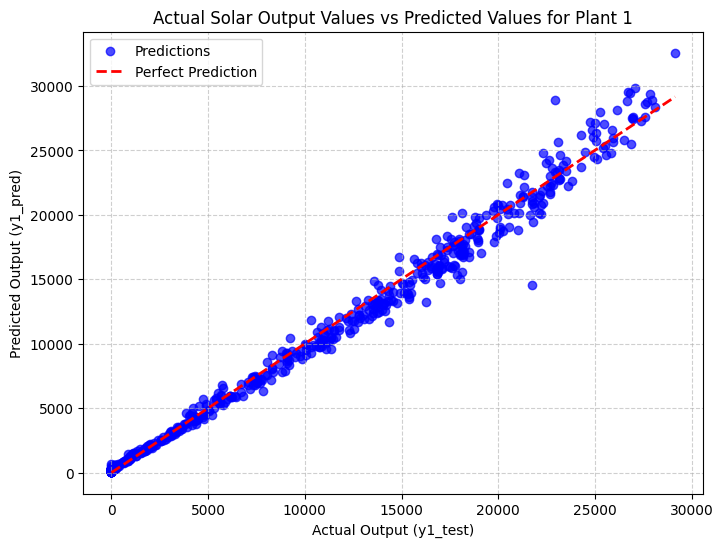

In [76]:
# Check the predicted vs actual values distribution
y1_pred = lr1.predict(X1_test) #Change based on the model

# Create a scatter plot with a diagonal line representing perfect predictions
plt.figure(figsize=(8, 6))
plt.scatter(y1_test, y1_pred, color='blue', marker='o', alpha=0.7, label='Predictions')
plt.plot([y1_test.min(), y1_test.max()], [y1_test.min(), y1_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1')
plt.xlabel('Actual Output (y1_test)')
plt.ylabel('Predicted Output (y1_pred)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

* As we can see for Plant 1, the result have narrow/tight distribution which suggests accurate predictions.

### Plant 2

#### Linear Regression

In [79]:
results_lr2 = eval_regression(lr2, X2_test, y2_test, X2_train, y2_train)

Performance Metrics for LinearRegression:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  1667.6510 ± 110.0843
  Train: 1662.2707 ± 35.6204

RMSE:
  Test:  2589.2538 ± 180.9860
  Train: 2587.5730 ± 45.0195

R2:
  Test:  0.8294 ± 0.0207
  Train: 0.8309 ± 0.0052

MAPE:
  Test:  1592166326640009728.0000 ± 177685251243879776.0000
  Train: 1589555323986640896.0000 ± 61803233905027320.0000

Single Run Metrics:

MAE:
  Test:  1646.4692
  Train: 1662.9130

RMSE:
  Test:  2519.5955
  Train: 2588.7209

MAPE:
  Test:  1690996228928025856.0000
  Train: 1590088156678507520.0000

R2:
  Test:  0.8436
  Train: 0.8308


#### Ridge Regression

In [80]:
results_ridge2 = eval_regression(ridge2, X2_test, y2_test, X2_train, y2_train)

Performance Metrics for Ridge:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  1688.7391 ± 113.1296
  Train: 1684.3442 ± 36.3465

RMSE:
  Test:  2600.6145 ± 187.2283
  Train: 2600.3115 ± 45.4807

R2:
  Test:  0.8279 ± 0.0217
  Train: 0.8292 ± 0.0053

MAPE:
  Test:  1648852157126738944.0000 ± 178035440768093856.0000
  Train: 1646208239525441536.0000 ± 63822270630412248.0000

Single Run Metrics:

MAE:
  Test:  1657.3999
  Train: 1680.3004

RMSE:
  Test:  2514.2578
  Train: 2598.3561

MAPE:
  Test:  1754524916381210368.0000
  Train: 1636834925694525952.0000

R2:
  Test:  0.8443
  Train: 0.8295


#### Lasso Regression

In [81]:
results_lasso2 = eval_regression(lasso2, X2_test, y2_test, X2_train, y2_train)

Performance Metrics for Lasso:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  1669.9518 ± 111.0310
  Train: 1664.6149 ± 35.8670

RMSE:
  Test:  2589.8376 ± 182.8746
  Train: 2588.2650 ± 44.9984

R2:
  Test:  0.8293 ± 0.0210
  Train: 0.8308 ± 0.0052

MAPE:
  Test:  1598810828712261376.0000 ± 176790233347927296.0000
  Train: 1596164835184790016.0000 ± 62001000356957296.0000

Single Run Metrics:

MAE:
  Test:  1647.4648
  Train: 1665.3844

RMSE:
  Test:  2515.7542
  Train: 2589.4115

MAPE:
  Test:  1700644324717971200.0000
  Train: 1596787149293550848.0000

R2:
  Test:  0.8441
  Train: 0.8307


#### Elasticnet Regression

In [82]:
results_elasticnet2 = eval_regression(elasticnet2, X2_test, y2_test, X2_train, y2_train)

Performance Metrics for ElasticNet:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  4463.3923 ± 108.7917
  Train: 4457.5661 ± 37.0571

RMSE:
  Test:  5071.7385 ± 169.7603
  Train: 5067.7465 ± 31.3252

R2:
  Test:  0.3476 ± 0.0085
  Train: 0.3514 ± 0.0042

MAPE:
  Test:  8310674358278534144.0000 ± 650947032380909440.0000
  Train: 8301242475551104000.0000 ± 88536336462131392.0000

Single Run Metrics:

MAE:
  Test:  4590.1316
  Train: 4458.4065

RMSE:
  Test:  5143.4421
  Train: 5068.3522

MAPE:
  Test:  8749564530810925056.0000
  Train: 8302990464869962752.0000

R2:
  Test:  0.3483
  Train: 0.3514


#### KNN

In [83]:
results_knn2 = eval_regression(knn2, X2_test, y2_test, X2_train, y2_train)

Performance Metrics for KNeighborsRegressor:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  924.1694 ± 101.5833
  Train: 748.9122 ± 18.9163

RMSE:
  Test:  2041.0173 ± 214.2754
  Train: 1670.6111 ± 46.9186

R2:
  Test:  0.8937 ± 0.0188
  Train: 0.9295 ± 0.0035

MAPE:
  Test:  162884460811504992.0000 ± 153750359238293952.0000
  Train: 129405106488809168.0000 ± 32011197003989936.0000

Single Run Metrics:

MAE:
  Test:  817.1945
  Train: 737.2241

RMSE:
  Test:  1851.5020
  Train: 1659.1857

MAPE:
  Test:  163941558079235872.0000
  Train: 128467035209933472.0000

R2:
  Test:  0.9156
  Train: 0.9305


#### Decesion Tree

In [84]:
results_dt2 = eval_regression(dt2, X2_test, y2_test, X2_train, y2_train)

Performance Metrics for DecisionTreeRegressor:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  1201.3744 ± 138.9529
  Train: 0.0000 ± 0.0000

RMSE:
  Test:  2804.1984 ± 293.5541
  Train: 0.0000 ± 0.0000

R2:
  Test:  0.7993 ± 0.0351
  Train: 1.0000 ± 0.0000

MAPE:
  Test:  163314110894157664.0000 ± 163658990671249664.0000
  Train: 0.0000 ± 0.0000

Single Run Metrics:

MAE:
  Test:  1044.9791
  Train: 0.0000

RMSE:
  Test:  2408.2751
  Train: 0.0000

MAPE:
  Test:  107356905716723920.0000
  Train: 0.0000

R2:
  Test:  0.8571
  Train: 1.0000


#### Random Forest

In [85]:
results_rf2 = eval_regression(rf2, X2_test, y2_test, X2_train, y2_train)

Performance Metrics for RandomForestRegressor:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  911.7674 ± 101.3128
  Train: 336.3921 ± 10.4414

RMSE:
  Test:  2075.9250 ± 211.8197
  Train: 777.6240 ± 28.7784

R2:
  Test:  0.8901 ± 0.0189
  Train: 0.9847 ± 0.0010

MAPE:
  Test:  161936726012784960.0000 ± 157227374353121632.0000
  Train: 59738291589426136.0000 ± 16197840777602540.0000

Single Run Metrics:

MAE:
  Test:  791.0029
  Train: 331.3793

RMSE:
  Test:  1820.2059
  Train: 762.3444

MAPE:
  Test:  143688671105101456.0000
  Train: 57509423639841952.0000

R2:
  Test:  0.9184
  Train: 0.9853


#### Xtreme Gradient Boost

In [86]:
results_xgb2 = eval_regression(xgb2, X2_test, y2_test, X2_train, y2_train)

Performance Metrics for XGBRegressor:

Cross-Validated Metrics (mean ± std):

MAE:
  Test:  1008.6819 ± 90.3717
  Train: 117.4451 ± 6.9691

RMSE:
  Test:  2281.8215 ± 181.7685
  Train: 243.9558 ± 22.7936

R2:
  Test:  0.8674 ± 0.0179
  Train: 0.9985 ± 0.0003

MAPE:
  Test:  173975006251358528.0000 ± 155259141492411104.0000
  Train: 22408740118856276.0000 ± 4315533964428061.5000

Single Run Metrics:

MAE:
  Test:  874.6440
  Train: 154.7191

RMSE:
  Test:  1929.5185
  Train: 326.9387

MAPE:
  Test:  166934738054117344.0000
  Train: 32387767782783164.0000

R2:
  Test:  0.9083
  Train: 0.9973


### Feature Importance in Linear Models

In [77]:
# Flatten the coefficient arrays
lr_coef = pd.Series(lr2.coef_.flatten())
ridge_coef = pd.Series(ridge2.coef_.flatten())
lasso_coef = pd.Series(lasso2.coef_.flatten())
elasticnet_coef = pd.Series(elasticnet2.coef_.flatten())

# Creating a DataFrame with coefficients
linear_model_coef = pd.DataFrame({'Feature': X2_train.columns,
                                  'lr_coef': lr_coef, 'ridge_coef': ridge_coef, 'lasso_coef': lasso_coef, 'elasticnet_coef': elasticnet_coef})

# Display coef DataFrame
display(linear_model_coef)

Feature       lr_coef    ridge_coef    lasso_coef  \
0  AMBIENT_TEMPERATURE   6144.087107   3542.116001   5390.220286   
1   MODULE_TEMPERATURE  -9729.155068  -3378.347766  -8010.924856   
2          IRRADIATION  24843.328703  20845.983364  23806.274734   

   elasticnet_coef  
0      1296.987166  
1      2017.132672  
2      2475.178525

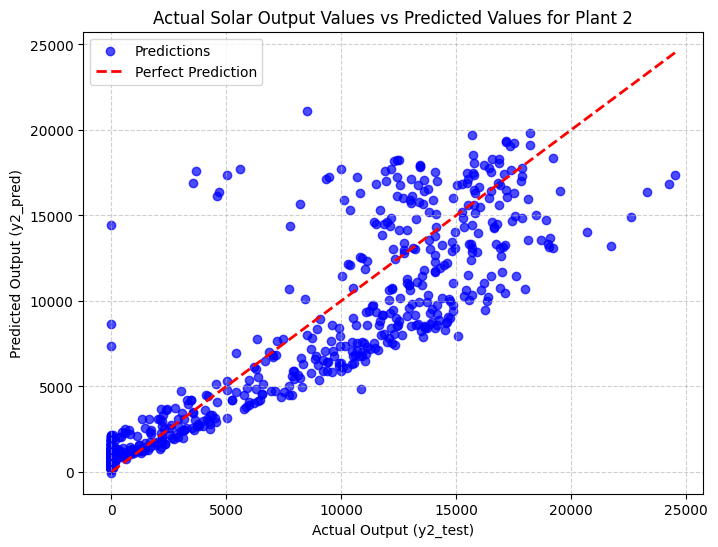

In [78]:
# Check the predicted vs actual values distribution
y2_pred = lr2.predict(X2_test) #Change based on the model

# Create a scatter plot with a diagonal line representing perfect predictions
plt.figure(figsize=(8, 6))
plt.scatter(y2_test, y2_pred, color='blue', marker='o', alpha=0.7, label='Predictions')
plt.plot([y2_test.min(), y2_test.max()], [y2_test.min(), y2_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title('Actual Solar Output Values vs Predicted Values for Plant 2')
plt.xlabel('Actual Output (y2_test)')
plt.ylabel('Predicted Output (y2_pred)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

- Observing Plant 2, the outcomes exhibit a somewhat dispersed distribution, particularly at higher values, signaling a less than optimal model.

- Slightly scattered distribution indicates suboptimal model.

- This can be credited to the irregularities in output, possibly brought forth by faulty modules that we found in EDA process

# Hyperparameter Tuning

This part will only be used if we want further analysis in using other algorithms other than linear regression, **but for now we will settle with linear regression since it gave good enough result and the fact that all the features used have linear correlation to target**.

# Conclusion

1. Plant 1, situated in a colder region of India, is at a higher elevation compared to Plant 2, providing a plausible explanation for the similar solar irradiation levels. This elevation may result in fewer clouds and less atmospheric interference, contributing to comparable solar irradiation levels despite the difference in geographical locations.

2. The PV modules in Plant 1 are more reliable, exhibiting 10 times the DC output of Plant 2, along with higher AC output stability.

3. Plant 1 demonstrates a stronger correlation between output and yield, indicating superior overall system efficiency compared to Plant 2, despite similar inverter efficiency.

4. Both plants appear to receive a comparable amount of sunlight daily, although Plant 2, potentially located in a cloudier region, displays slightly more erratic irradiation values. Conversely, Plant 1 may be situated at an elevated location with fewer clouds and lower temperatures. Maintenance may also be required for the modules in Plant 2.

5. Plant 2 experiences higher temperatures primarily due to diffused sunlight, which lacks the energy and wavelength range to excite electrons in the PV cells.

6. Plant 1 exhibits greater predictability than Plant 2, characterized by a tighter regression and lower RMSE values.

7. Optimization of the models can be achieved by addressing various factors, such as inadequate features for supervised learning, the need for additional features like weather data to enhance model accuracy, insufficient data points (30 days) for effective training in weather-dependent systems, faulty modules in Plant 2 leading to misleading data and a loose linear regression, and potential human errors in analysis.

8. To enhance the overall efficiency of the solar power plant, consider the following data-driven solutions: conduct maintenance on the solar modules in Plant 2 to improve irradiation, and increase the DC output of Plant 2 by adding more solar modules, especially if the plant is situated in a cloudy region.